
![](http://i.imgur.com/0Uqu3yw.jpg)


# Kobe Capstone Project

> OVERVIEW:
Kobe Bryant marked his retirement from basketball by scoring 60 points in his final game as a member of the Los Angeles Laker team on Wednesday, April 12, 2016. Starting to play professional basketball at the age of 17, Kobe earned the sport’s highest accolades throughout his long career.  Using 20 years of data on Kobe's shots made and shots missed, can you predict which shots will be successful?


## Objectives
1. Overall Objective: Build a predictive model to classify shots as missed or made, producing:
    * 1.1 __A logistic Regression Model__
    * 1.2 __A Linear Discrimination Analysis (LDA) model__
2. Build models to provide arguments and evidence for or against the propositions below. For Each Quanitfy your findings with statistical evidence _(Test, CI, plots, etc.)_
    * 2.1. The odds of Kobe making a shot decreases with respect to the distance he is from the hoop.
    * 2.2. The probability of Kobe making a shot decreases linearly with respects to the distacne he is from the hoop.
    * 2.3. The relationship between the distance Kobe is from te basket and the odds of him making the shot is different if they are in the playoffs.


In [330]:
import pandas as pd
import numpy as np

# Statistical Packages
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# import plotting libraries
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# style
%matplotlib inline
plt.style.use('seaborn-white')

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100, 'display.float_format', lambda x: '%.3f' % x)
#sns.set(style='white', context='notebook', palette='deep')
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("paper")

# https://seaborn.pydata.org/tutorial/color_palettes.html?highlight=color

# Seven hls color palette (right)
#current_palette_7 = sns.color_palette("hls", 7)
#sns.set_palette(current_palette_7)

# inverted colors: https://encycolorpedia.com/c0d74d
# lakers colors: https://teamcolorcodes.com/los-angeles-lakers-color-codes/
# inverted 
# lakers_color = ["#c0d74d",  "#2550ff","#3498db", "#95a5a6", "#e74c3c", "#2ecc71"]
lakers_color = ["#552583", '#FDB927', "#000000", "#ffe4e1","#95a5a6", "#e74c3c"]
sns.set_palette(lakers_color)

In [331]:
%%html
<div id="data"><p><iframe src="./data/data_dictionary.txt" frameborder="2" height="300"width="97%"></iframe></p></div>

In [59]:
sns.color_palette()

[(0.7529411764705882, 0.8431372549019608, 0.30196078431372547),
 (0.1450980392156863, 0.3137254901960784, 1.0),
 (0.20392156862745098, 0.596078431372549, 0.8588235294117647),
 (0.5843137254901961, 0.6470588235294118, 0.6509803921568628),
 (0.9058823529411765, 0.2980392156862745, 0.23529411764705882),
 (0.1803921568627451, 0.8, 0.44313725490196076)]

In [60]:
sns.choose_colorbrewer_palette('sequential')

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Pu…

[(0.9575547866205305, 0.9575547866205305, 0.9575547866205305),
 (0.9012072279892349, 0.9012072279892349, 0.9012072279892349),
 (0.8328950403690888, 0.8328950403690888, 0.8328950403690888),
 (0.7502191464821223, 0.7502191464821223, 0.7502191464821223),
 (0.6434140715109573, 0.6434140715109573, 0.6434140715109573),
 (0.5387158785082661, 0.5387158785082661, 0.5387158785082661),
 (0.440322952710496, 0.440322952710496, 0.440322952710496),
 (0.342883506343714, 0.342883506343714, 0.342883506343714),
 (0.22329873125720878, 0.22329873125720878, 0.22329873125720878),
 (0.10469819300269129, 0.10469819300269129, 0.10469819300269129)]

In [61]:
train = pd.read_csv("./data/modelData.csv")
test = pd.read_csv("./data/predData.csv")
train.head()

,recId,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id,attendance,arena_temp,avgnoisedb
0,1,Jump Shot,Jump Shot,12,20000012,34.044,-157,0,-118.427,10,1,0,2000-01,22,15,0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,36830,LAL @ POR,POR,2,14707,69,94.060
1,4,Driving Dunk Shot,Dunk,155,20000012,34.044,0,0,-118.270,6,2,0,2000-01,19,0,1,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,36830,LAL @ POR,POR,5,14707,69,94.060
2,5,Jump Shot,Jump Shot,244,20000012,34.055,-145,-11,-118.415,9,3,0,2000-01,32,14,0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,36830,LAL @ POR,POR,6,14707,69,94.060
3,6,Layup Shot,Layup,251,20000012,34.044,0,0,-118.270,8,3,0,2000-01,52,0,1,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,36830,LAL @ POR,POR,7,14707,69,94.060
4,7,Jump Shot,Jump Shot,265,20000012,33.936,-65,108,-118.335,6,3,0,2000-01,12,12,1,2PT Field Goal,Left Side(L),In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,36830,LAL @ POR,POR,9,14707,69,94.060


In [62]:
print("Train data: ")
print("Training data Observations (rows): ", train.shape[0])
print("Training data Factors (columns): ", train.shape[1])
print("----------------------------------------------------")
print("Test data: ")
print("Test data Observations (rows): ", test.shape[0])
print("Test data Factors (columns): ", test.shape[1])

Train data: 
Training data Observations (rows):  20697
Training data Factors (columns):  29
----------------------------------------------------
Test data: 
Test data Observations (rows):  5000
Test data Factors (columns):  28


We can see from the above output that the train dataset has one additional column than the test dataset, which is appropriately due to the fact the train dataset has `shot_made_flag` which is the response variable tha is our objective to predict.

__Predict variable ($y$)__ - did Kobe make the shot? (binary 1-make / 0-miss)

### Preliminary Summary Statistics and Data Analysis

In [63]:
print("Kobe Preliminary Summary Statistics (training dataset)")
print("Number of career shots: ", len(train))
print("Average (Mean) Shot Made per Game: ", str("$"), round(train.groupby('game_id')['shot_made_flag'].mean().values.mean(),3))
print("Most Shots Made in a Game: ", train.groupby('game_id')['shot_made_flag'].sum().values.max())
print("Number of game made more than 15 shots: ", sum(train.groupby('game_id')['shot_made_flag'].sum().values > 15))
print("Number of game made less than 5 shots: ", sum(train.groupby('game_id')['shot_made_flag'].sum().values < 5))
print("Variability Shot Make (standard dev): ", round(train.groupby('game_id')['shot_made_flag'].sum().values.std(),3))

Kobe Preliminary Summary Statistics (training dataset)
Number of career shots:  20697
Average (Mean) Shot Made per Game:  $ 0.446
Most Shots Made in a Game:  18
Number of game made more than 15 shots:  6
Number of game made less than 5 shots:  523
Variability Shot Make (standard dev):  3.02


In [64]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20697 entries, 0 to 20696
Data columns (total 29 columns):
recId                 20697 non-null int64
action_type           20697 non-null object
combined_shot_type    20697 non-null object
game_event_id         20697 non-null int64
game_id               20697 non-null int64
lat                   20697 non-null float64
loc_x                 20697 non-null int64
loc_y                 20697 non-null int64
lon                   20697 non-null float64
minutes_remaining     20697 non-null int64
period                20697 non-null int64
playoffs              20697 non-null int64
season                20697 non-null object
seconds_remaining     20697 non-null int64
shot_distance         20697 non-null int64
shot_made_flag        20697 non-null int64
shot_type             20697 non-null object
shot_zone_area        20697 non-null object
shot_zone_basic       20697 non-null object
shot_zone_range       20697 non-null object
team_id             

__Data Quality Check__ lets check the columsn that contain `NaN` values.

In [65]:
train.columns[train.isnull().any()].tolist()

[]

combine data sets for EDA

In [66]:
kobe = pd.concat((train, test), axis = 0, ignore_index=True)
#kobe = pd.read_csv("./data/data.csv")
print("Combined data: ")
print("Combined data Observations (rows): ", kobe.shape[0])
print("Combined data Factors (columns): ", kobe.shape[1])

Combined data: 
Combined data Observations (rows):  25697
Combined data Factors (columns):  29


## Exploratory Data Analysis

To get started with exploratory analysis, we set out to first review Kobe's distribution of shots made vs shots missed. 

shot_made_flag
0.000    11431
1.000     9266
dtype: int64


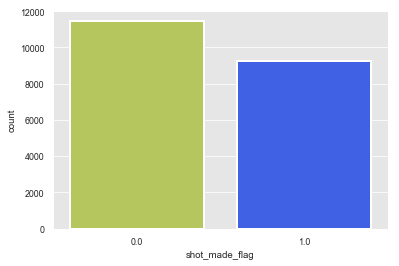

In [67]:
sns.countplot('shot_made_flag',  data=kobe, linewidth=2) #hue='shot_type',
print(kobe.groupby('shot_made_flag').size())
#print(kobe.groupby(['shot_type','shot_made_flag']).size())

Next let see the distirbution of kobe's `shot zone` (where kobe shot the ball on the court) and the number of time he made or missed the shot.

['Mid-Range' 'Restricted Area' 'In The Paint (Non-RA)' 'Above the Break 3'
 'Backcourt' 'Right Corner 3' 'Left Corner 3']


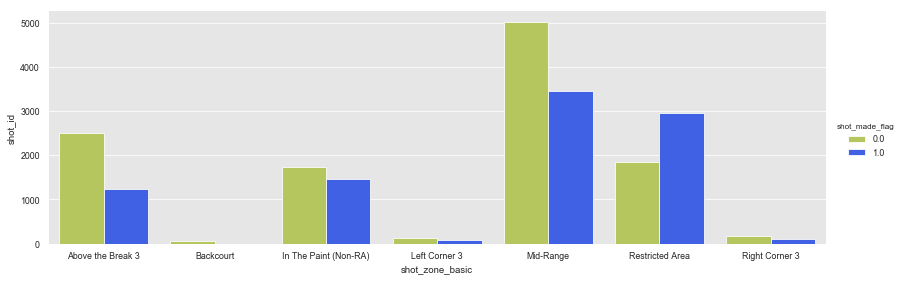

In [68]:
print(kobe.shot_zone_basic.unique())
sns.catplot(x='shot_zone_basic', y='shot_id',
            hue='shot_made_flag', kind='bar', height=4, aspect=11.7/4,
           data=kobe.groupby(['shot_zone_basic','shot_made_flag'])['shot_id'].count().reset_index())

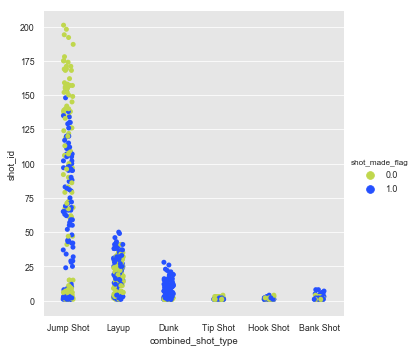

In [69]:
sns.catplot(x='combined_shot_type', y='shot_id', hue='shot_made_flag', data=kobe.groupby(['season','period','combined_shot_type','shot_made_flag'])['shot_id'].count().reset_index())

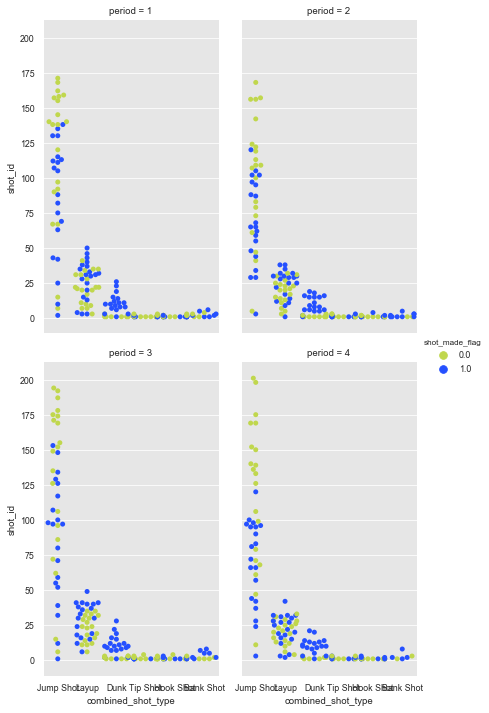

In [70]:
sns.catplot(x="combined_shot_type", y="shot_id", hue="shot_made_flag",
            col="period", aspect=.6,
            kind="swarm",  col_wrap=2, 
            data=kobe[kobe.period <=4].groupby(['season',
                                                'period','combined_shot_type','shot_made_flag'])['shot_id'].count().reset_index())

KeyboardInterrupt: 

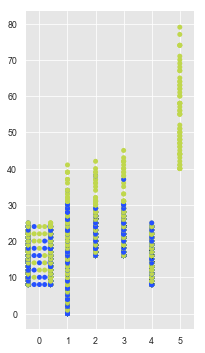

In [158]:
sns.catplot(x="shot_zone_area", y="shot_distance", hue="shot_made_flag", aspect=.6,
            kind="swarm", 
            data=kobe)

In [153]:
kobe.shot_zone_area.unique()

array(['Left Side(L)', 'Center(C)', 'Left Side Center(LC)',
       'Right Side Center(RC)', 'Right Side(R)', 'Back Court(BC)'],
      dtype=object)

In [16]:
len(kobe.game_id.unique())

1559

### General Statistics


![](http://a.espncdn.com/photo/2016/0418/r75275_1600x1000cc.jpg)

No handles with labels found to put in legend.


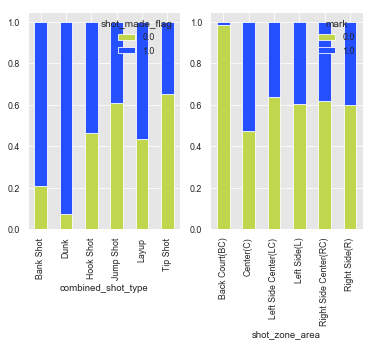

In [17]:

fig, axes3 = plt.subplots(1,2)
table = pd.crosstab(kobe.combined_shot_type, kobe.shot_made_flag)

# https://stackoverflow.com/questions/51977217/getting-empty-plots-when-using-subplots-in-matplotlib
ax = table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes3[0])
plt.legend(title='mark', loc=8)

table = pd.crosstab(kobe.shot_zone_area, kobe.shot_made_flag)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes3[1])
plt.legend(title='mark', loc=0)
plt.show()

It appears that `combined_shot_type` can be in the consideration of a predictor variable, especially `Dunks`, `Bank Shots`, which are Kobe's bread and butter. 

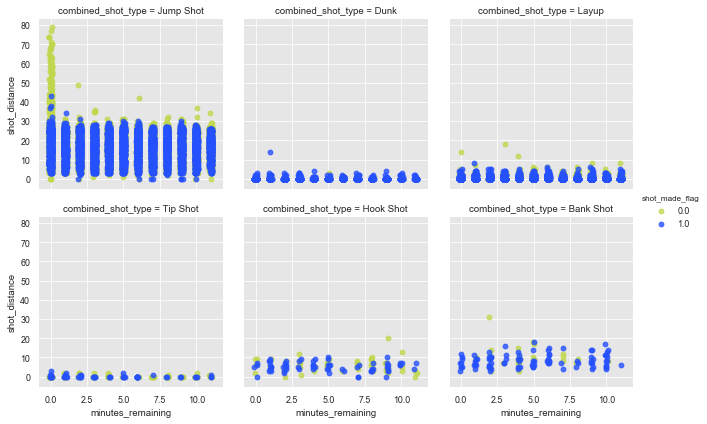

In [18]:
# https://seaborn.pydata.org/tutorial/axis_grids.html
g = sns.FacetGrid(kobe, col="combined_shot_type", hue="shot_made_flag",
                  col_wrap=3, margin_titles=True)
g.map(sns.regplot, "minutes_remaining",  "shot_distance", 
      fit_reg=False, x_jitter=.1)
g.add_legend();

The above graph appears that when reviewing the different combinaitons of Kobe's shot type, Kobe's `bread and butter` are contnued to indicate predictor variables for Kobe's made shots for the exeption of `combined_shot_type = Jump Shot` where kobe is pretty consistent in respects to distance, when there is more than 1 min remain in the quarter. 



__Kobe's Shot Zone Area__

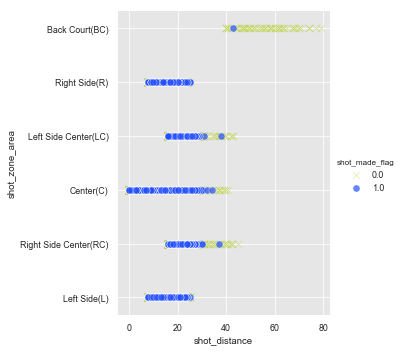

In [19]:
g = sns.FacetGrid(kobe, hue="shot_made_flag", height=5,aspect=1, hue_kws={"marker": ["x", "o"]})
g.map(plt.scatter, "shot_distance", "shot_zone_area", s=50, alpha=.7, linewidth=.5, edgecolor="white")
g.add_legend();

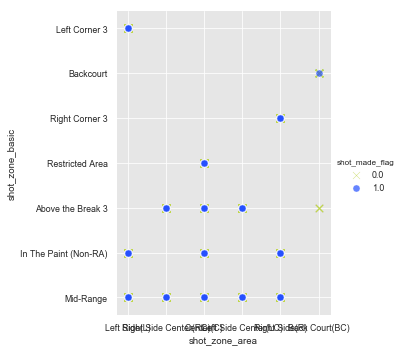

In [20]:
g = sns.FacetGrid(kobe, hue="shot_made_flag", height=5,aspect=1, hue_kws={"marker": ["x", "o"]})
g.map(plt.scatter, "shot_zone_area", "shot_zone_basic", s=50, alpha=.7, linewidth=.5, edgecolor="white")
g.add_legend();

In [71]:
kobe[(kobe.shot_zone_area=="Right Side Center(RC)") & (kobe.shot_distance>30) & (kobe.shot_made_flag==1.0)]

,action_type,arena_temp,attendance,avgnoisedb,combined_shot_type,game_date,game_event_id,game_id,lat,loc_x,loc_y,lon,matchup,minutes_remaining,opponent,period,playoffs,recId,season,seconds_remaining,shot_distance,shot_id,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name
2772,Jump Shot,73,15798,95.380,Jump Shot,37653,347,20200676,33.704,166,340,-118.104,LAL vs. UTA,0,UTA,3,0,4113,2002-03,0,37,4114,1.000,3PT Field Goal,Right Side Center(RC),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers


Gaining an understanding of Kobe's shot placement on the floor, obviosly, `Back Court (BC)` can be said to be a great predictor for when kobe misses the shot, seemingly enough, it appears Kobe shoot consitantly better in roughly the same range location as his shot moves further away from the center of the court, indicated by the `Right Side (R)` and `Left Side (L)` variables. these will make for good dummy variables, which we will create as `kobe_shot_loc` as:

In [72]:
kobe.loc[(kobe.shot_zone_area!='Back Court(BC)') & (kobe.shot_distance<30), 'kobe_shot_loc'] = 1
kobe.loc[(kobe.kobe_shot_loc!=1), 'kobe_shot_loc'] = 0

In [110]:
kobe.head()

,action_type,arena_temp,attendance,avgnoisedb,combined_shot_type,game_date,game_event_id,game_id,lat,loc_x,loc_y,lon,matchup,minutes_remaining,opponent,period,playoffs,recId,season,seconds_remaining,shot_distance,shot_id,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,kobe_shot_loc
0,Jump Shot,69,14707,94.060,Jump Shot,36830,12,20000012,34.044,-157,0,-118.427,LAL @ POR,10,POR,1,0,1,2000-01,22,15,2,0.000,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,1.000
1,Driving Dunk Shot,69,14707,94.060,Dunk,36830,155,20000012,34.044,0,0,-118.270,LAL @ POR,6,POR,2,0,4,2000-01,19,0,5,1.000,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,1.000
2,Jump Shot,69,14707,94.060,Jump Shot,36830,244,20000012,34.055,-145,-11,-118.415,LAL @ POR,9,POR,3,0,5,2000-01,32,14,6,0.000,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,1.000
3,Layup Shot,69,14707,94.060,Layup,36830,251,20000012,34.044,0,0,-118.270,LAL @ POR,8,POR,3,0,6,2000-01,52,0,7,1.000,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,1.000
4,Jump Shot,69,14707,94.060,Jump Shot,36830,265,20000012,33.936,-65,108,-118.335,LAL @ POR,6,POR,3,0,7,2000-01,12,12,9,1.000,2PT Field Goal,Left Side(L),In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,1.000


In [111]:
kobe.minutes_remaining.unique()

array([10,  6,  9,  8,  1, 11,  7,  2,  0,  5,  3,  4], dtype=int64)

### Pearson Correlation

Utilize Perason correlation coefficient to gain a better understanding of the predictor varaibales and their strength in relationship to whether Kobe makes or misses a shot. 

In [23]:
kobe_corr = kobe.corr()
kobe_corr['shot_made_flag'].sort_values(ascending=False)

shot_made_flag       1.000
lat                  0.148
kobe_shot_loc        0.065
seconds_remaining    0.031
minutes_remaining    0.028
loc_x               -0.001
lon                 -0.001
playoffs            -0.001
game_id             -0.002
shot_id             -0.013
period              -0.032
game_event_id       -0.037
loc_y               -0.148
shot_distance       -0.198
team_id                nan
Name: shot_made_flag, dtype: float64

It appears that `shot distance`, `log_y` and `lat` are the top 3 correlatied variables. with `lat` being an interesting because, _im assuming_ this is a measure of the `latitude` of the statium, which mean there is a positive (not strong at all...) correlation with Kobe's shot and more teams that play in more northing located teams...idk about this..

---
## Feature Engineering

The first feature that come that can assist with predicing kobe's shot is to add a feature (or column) to indicate whether he made or missed his last shot. Make sense right... if we can have prior knowedge if Kobe made or missed his last shot, it can reasonable be an indicator as to whether he will make or miss his current/future shot with some range of standard error. Therefore lets create a column that indicate whether he made or miss his last shot. We also need to account for the current shot and last shot were all in the same period of the same game

In [217]:
kobe = kobe.sort_values(by=["game_id","shot_id"], ascending=True)

# prior shot made
kobe['prior_shot_made'] =(kobe.groupby(['game_id'])['shot_made_flag'].shift(1))

# include prior shot made from last record of shot from that game
kobe['prior_shot_made'] = (kobe.groupby("game_id")['prior_shot_made'].transform(lambda x: x.ffill().bfill()))

# cumsum made shots
#kobe['cum_shot_made'] = (kobe.groupby(['game_id'])['shot_made_flag'].cumsum())
#kobe['cum_shot_made'] =(kobe.groupby(kobe.prior_shot_made.shift(-1).eq(0).cumsum()).cumcount())

In [274]:
# cumsum made shots
kobe['cum_shot_made'] = kobe.shot_made_flag
kobe.loc[kobe.shot_made_flag.isnull(), 'cum_shot_made'] = 0
#kobe['cum_shot_made'] = (kobe.groupby(['game_id'])['cum_shot_made'].eq(0).cumsum())
kobe['cum_shot_made'] = (kobe.groupby(kobe.cum_shot_made.eq(0).cumsum()).cumcount())
kobe.loc[kobe.shot_made_flag.isnull(), 'cum_shot_made'] = np.nan
kobe['cum_shot_made'] = (kobe.groupby(['game_id'])['cum_shot_made'].transform(lambda x: x.ffill().bfill()))

Next we will create a unique identifier for each team with an `Opp` suffix. 

In [81]:
kobe['opp'] = kobe.matchup.apply(lambda x: x[-3:])
kobe['oppSeason'] = kobe.matchup.apply(lambda x: x[-3:])+kobe.season

In [82]:
kobe.matchup.unique()

array(['LAL @ POR', 'LAL vs. UTA', 'LAL @ VAN', 'LAL vs. LAC',
       'LAL @ HOU', 'LAL @ SAS', 'LAL vs. HOU', 'LAL vs. DEN',
       'LAL @ SAC', 'LAL @ DEN', 'LAL vs. CHI', 'LAL vs. GSW',
       'LAL vs. MIN', 'LAL @ LAC', 'LAL vs. IND', 'LAL @ SEA',
       'LAL vs. SAS', 'LAL vs. DAL', 'LAL vs. PHI', 'LAL @ GSW',
       'LAL vs. SEA', 'LAL vs. DET', 'LAL vs. MIL', 'LAL vs. VAN',
       'LAL @ TOR', 'LAL @ MIA', 'LAL @ DAL', 'LAL vs. POR', 'LAL @ PHX',
       'LAL vs. CLE', 'LAL @ UTA', 'LAL vs. MIA', 'LAL vs. NJN',
       'LAL @ NYK', 'LAL @ CLE', 'LAL @ MIN', 'LAL vs. CHH',
       'LAL vs. SAC', 'LAL vs. PHX', 'LAL @ NJN', 'LAL @ PHI',
       'LAL @ CHH', 'LAL @ IND', 'LAL vs. TOR', 'LAL @ DET', 'LAL @ WAS',
       'LAL @ ORL', 'LAL @ ATL', 'LAL @ MIL', 'LAL vs. NYK',
       'LAL vs. MEM', 'LAL vs. ORL', 'LAL @ MEM', 'LAL @ CHI',
       'LAL vs. WAS', 'LAL vs. ATL', 'LAL vs. BOS', 'LAL @ BOS',
       'LAL vs. NOH', 'LAL @ NOH', 'LAL @ UTH', 'LAL vs. SAN',
       'LAL @ NOK', 'LAL @ 

Create variable for home game

In [83]:
kobe['home_game'] = kobe.matchup.apply(lambda x: 0 if "@" in x else 1)

In [84]:
kobe.season.unique()

array(['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06',
       '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12',
       '2012-13', '2013-14', '2014-15', '2015-16', '1996-97', '1997-98',
       '1998-99', '1999-00'], dtype=object)

Next an interesting feature would be to get a better timeline of the game, while we have both `minutes_remaining` and `seconds remaining` these would actually be quite arbitrary to the model if we just fed in directly as indicated by the correlation. it would be true that the correlation of time and shots made should be correlated or at least `shot typ`e and time but currently they are broken out in an unuseful format for our model to use effectively. So therefore we will create another timeline to get `secFromGameStart`

In [85]:
# Thanks: https://www.kaggle.com/selfishgene/psychology-of-a-professional-athlete
kobe['secondsFromPeriodEnd'] = 60*kobe['minutes_remaining']+kobe['seconds_remaining']
kobe['secondsFromPeriodStart'] = 60*(11-kobe['minutes_remaining'])+(60-kobe['seconds_remaining'])
kobe['secondsFromGameStart'] = (kobe['period'] <= 4).astype(int)*(kobe['period']-1)*12*60 + (kobe['period'] > 4).astype(int)*((kobe['period']-4)*5*12*60) + kobe['secondsFromPeriodStart']

In [30]:
kobe.team_name.unique()

array(['Los Angeles Lakers'], dtype=object)

#### Data From Another Source
Atfer a quick search, found [bakcsetball-reference.com](https://www.basketball-reference.com/players/b/bryanko01.html) that we used their:
* Per Game
* Advanced
* Game won / loss

to assist with addtional information for a better preditive model. 

In [86]:
pergame = pd.read_csv("./data/kobe_per_game_bball_ref.csv")[['Season','FG', 'FGA', 'FG%','3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%','PTS']]
pergame.rename(columns={'Season':'season'}, inplace=True)
kobe = pd.merge(kobe, pergame, on="season", how='left',suffixes=('', '_pg') )
kobe.head()

,action_type,arena_temp,attendance,avgnoisedb,combined_shot_type,game_date,game_event_id,game_id,lat,loc_x,loc_y,lon,matchup,minutes_remaining,opponent,period,playoffs,recId,season,seconds_remaining,shot_distance,shot_id,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,kobe_shot_loc,cum_shot_made,prior_shot_made,opp,oppSeason,home_game,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,PTS
0,Jump Shot,69,14707,94.060,Jump Shot,36830,12,20000012,34.044,-157,0,-118.427,LAL @ POR,10,POR,1,0,1,2000-01,22,15,2,0.000,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,1.000,0.000,nan,POR,POR2000-01,0,622,98,98,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500
1,Jump Shot,69,14707,94.060,Jump Shot,36830,35,20000012,33.909,-101,135,-118.371,LAL @ POR,7,POR,1,0,2,2000-01,45,16,3,nan,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,1.000,nan,0.000,POR,POR2000-01,0,465,255,255,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500
2,Jump Shot,69,14707,94.060,Jump Shot,36830,43,20000012,33.869,138,175,-118.132,LAL @ POR,6,POR,1,0,3,2000-01,52,22,4,nan,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,1.000,nan,nan,POR,POR2000-01,0,412,308,308,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500
3,Driving Dunk Shot,69,14707,94.060,Dunk,36830,155,20000012,34.044,0,0,-118.270,LAL @ POR,6,POR,2,0,4,2000-01,19,0,5,1.000,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,1.000,1.000,nan,POR,POR2000-01,0,379,341,1061,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500
4,Jump Shot,69,14707,94.060,Jump Shot,36830,244,20000012,34.055,-145,-11,-118.415,LAL @ POR,9,POR,3,0,5,2000-01,32,14,6,0.000,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,1.000,1.000,1.000,POR,POR2000-01,0,572,148,1588,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500


In [87]:
adv_bb = pd.read_csv("./data/kobe_advanced_bball_ref.csv")[['Season','PER', 'TS%', '3PAr',
       'FTr','OBPM']]
adv_bb.rename(columns={'Season':'season'}, inplace=True)
kobe = pd.merge(kobe, adv_bb, on="season", how='left',suffixes=('', '_pg') )
kobe.head()

,action_type,arena_temp,attendance,avgnoisedb,combined_shot_type,game_date,game_event_id,game_id,lat,loc_x,loc_y,lon,matchup,minutes_remaining,opponent,period,playoffs,recId,season,seconds_remaining,shot_distance,shot_id,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,kobe_shot_loc,cum_shot_made,prior_shot_made,opp,oppSeason,home_game,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,PTS,PER,TS%,3PAr,FTr,OBPM
0,Jump Shot,69,14707,94.060,Jump Shot,36830,12,20000012,34.044,-157,0,-118.427,LAL @ POR,10,POR,1,0,1,2000-01,22,15,2,0.000,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,1.000,0.000,nan,POR,POR2000-01,0,622,98,98,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300
1,Jump Shot,69,14707,94.060,Jump Shot,36830,35,20000012,33.909,-101,135,-118.371,LAL @ POR,7,POR,1,0,2,2000-01,45,16,3,nan,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,1.000,nan,0.000,POR,POR2000-01,0,465,255,255,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300
2,Jump Shot,69,14707,94.060,Jump Shot,36830,43,20000012,33.869,138,175,-118.132,LAL @ POR,6,POR,1,0,3,2000-01,52,22,4,nan,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,1.000,nan,nan,POR,POR2000-01,0,412,308,308,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300
3,Driving Dunk Shot,69,14707,94.060,Dunk,36830,155,20000012,34.044,0,0,-118.270,LAL @ POR,6,POR,2,0,4,2000-01,19,0,5,1.000,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,1.000,1.000,nan,POR,POR2000-01,0,379,341,1061,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300
4,Jump Shot,69,14707,94.060,Jump Shot,36830,244,20000012,34.055,-145,-11,-118.415,LAL @ POR,9,POR,3,0,5,2000-01,32,14,6,0.000,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,1.000,1.000,1.000,POR,POR2000-01,0,572,148,1588,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300


add career rating stats
I had to add 500 rating when kobe was not rated
https://stats.nba.com/player/977/career/

In [88]:
rating = pd.read_csv("./data/career_ratings.csv")
kobe = pd.merge(kobe, rating, on="season", how='left')
kobe.head()

,action_type,arena_temp,attendance,avgnoisedb,combined_shot_type,game_date,game_event_id,game_id,lat,loc_x,loc_y,lon,matchup,minutes_remaining,opponent,period,playoffs,recId,season,seconds_remaining,shot_distance,shot_id,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,kobe_shot_loc,cum_shot_made,prior_shot_made,opp,oppSeason,home_game,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,PTS,PER,TS%,3PAr,FTr,OBPM,PTS_rating,FGM_rating,FGA_rating,FG%_rating,3PM_rating,3PA_rating,3P%_rating
0,Jump Shot,69,14707,94.060,Jump Shot,36830,12,20000012,34.044,-157,0,-118.427,LAL @ POR,10,POR,1,0,1,2000-01,22,15,2,0.000,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,1.000,0.000,nan,POR,POR2000-01,0,622,98,98,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81
1,Jump Shot,69,14707,94.060,Jump Shot,36830,35,20000012,33.909,-101,135,-118.371,LAL @ POR,7,POR,1,0,2,2000-01,45,16,3,nan,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,1.000,nan,0.000,POR,POR2000-01,0,465,255,255,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81
2,Jump Shot,69,14707,94.060,Jump Shot,36830,43,20000012,33.869,138,175,-118.132,LAL @ POR,6,POR,1,0,3,2000-01,52,22,4,nan,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,1.000,nan,nan,POR,POR2000-01,0,412,308,308,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81
3,Driving Dunk Shot,69,14707,94.060,Dunk,36830,155,20000012,34.044,0,0,-118.270,LAL @ POR,6,POR,2,0,4,2000-01,19,0,5,1.000,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,1.000,1.000,nan,POR,POR2000-01,0,379,341,1061,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81
4,Jump Shot,69,14707,94.060,Jump Shot,36830,244,20000012,34.055,-145,-11,-118.415,LAL @ POR,9,POR,3,0,5,2000-01,32,14,6,0.000,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,1.000,1.000,1.000,POR,POR2000-01,0,572,148,1588,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81


creating another variable to indicate whether Lakers won the game or not

In [89]:
wl = pd.read_csv("./data/kobe_win_loss.csv")
#wl = pd.read_csv("./data/kobe_win_loss_kaggle.csv")
kobe = pd.merge(kobe, wl, on="game_date", how="left")

In [90]:
len(kobe)

25697

In [91]:
wl.head()

,game_date,WL,game_won,score_ratio,OppSeason,OppDefRank,OppDef_Rating,Conf,Div,Same_Conf,Same_Div,Opp_margin_of_victory,LAL_Season,LA_mov,LA_offRating,net_la_v_oppd_rating
0,35370,W,1,14,PHO1997,20,109.440,W,P,1,1,0.660,LAL1997,4.270,108.340,-1.100
1,35372,W,1,6,MIN1997,15,108.060,W,M,1,0,-1.480,LAL1997,4.270,108.340,0.280
2,35374,W,1,6,NYK1997,2,101.680,E,A,0,0,3.120,LAL1997,4.270,108.340,6.660
3,35375,L,0,-10,CHH1997,22,109.650,E,C,0,0,1.870,LAL1997,4.270,108.340,-1.310
4,35377,L,0,-1,TOR1997,16,108.570,E,C,0,0,-3.120,LAL1997,4.270,108.340,-0.230


In [92]:
kobe.game_date[0]

36830

create variable whether kobe had a 10 rating in the NBA or not.

In [276]:
kobe['top_rated'] = kobe.PTS_rating.apply(lambda x: 1 if x<20 else 0)

Create a hothand function to group kobe shots based on the number consecutive shots

In [281]:
def hothand(y):
    if y  > 4:
        return 'hot hand' # use to be 'fire'
    elif y == 3:
        return 'hot hand'
    elif y > 0:
        return 'heat'
    elif y == 0:
        return 'nil'
    elif y < 0:
        return 'cold'
kobe['hot_hand'] = [hothand(k) for k in kobe.cum_shot_made.values]

In [282]:
kobe['hot_hand'] = (kobe.groupby("game_id")['hot_hand'].transform(lambda x: x.bfill().ffill()))

Lets see the distribution of the hothand function on Kobe.

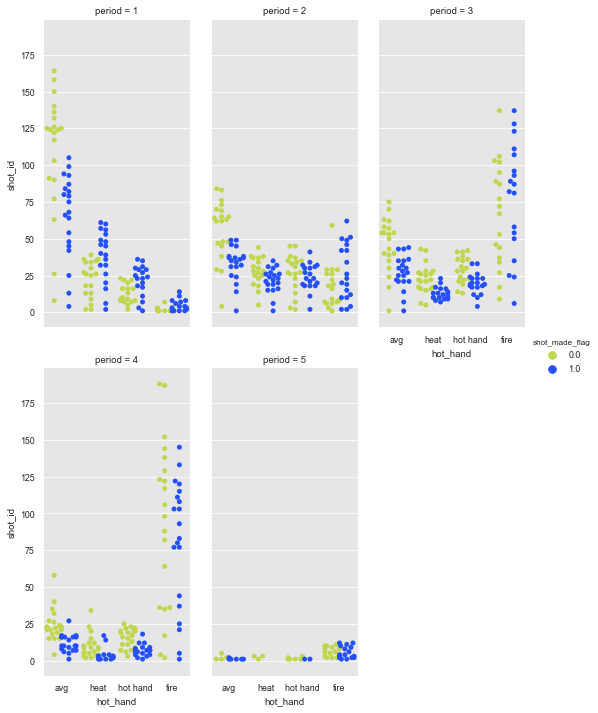

In [95]:
g= sns.catplot(x="hot_hand", y="shot_id", hue="shot_made_flag",
            col="period", aspect=.5,
            kind="swarm", col_wrap=3, dodge=True,
            data=kobe[kobe.period <=5].groupby(['season','period','hot_hand','shot_made_flag'])['shot_id'].count().reset_index())

Lets create a feature to keep track of Kobe's current points. Perhaps the more points Kobe has the higher likelihood we can predict whether his next shot will go in.

2 Pts and 3Pts now we convert each make and miss to a score and then we cumulatively sum it for a running average.

In [283]:
kobe.loc[(kobe['shot_made_flag']==1) & (kobe['shot_type']=='2PT Field Goal'),'pts'] = 2
kobe.loc[(kobe['shot_made_flag']==1) & (kobe['shot_type']=='3PT Field Goal'),'pts'] = 3
kobe.loc[(kobe['shot_made_flag']==0) | (kobe.shot_made_flag.isnull()) ,'pts'] = 0
kobe['pts'] = (kobe.groupby(['game_id'])['pts'].cumsum())

Next lets create a field goal percentage

Formula Field goal percentage (FG%) calculates as:

![](https://s0.wp.com/latex.php?latex=%5Cfrac%7B%5Ctext%7BField+Goals%7D%7D%7B%5Ctext%7BField+Goal+Attempts%7D%7D&bg=ffffff&fg=000&s=0)

In [308]:
# 2 Pointers
kobe.loc[(kobe['shot_type']=='2PT Field Goal'),'field_goal_attempts'] = 1
kobe.loc[(kobe['shot_type']=='3PT Field Goal'),'field_goal_attempts'] = 0
kobe.loc[(kobe['shot_made_flag']==1) & (kobe['shot_type']=='2PT Field Goal'),'field_goal'] = 1
kobe.loc[(kobe['shot_made_flag']==0) & (kobe['shot_type']=='2PT Field Goal'),'field_goal'] = 0

# make no assuption on test data
#kobe.loc[kobe.shot_made_flag.isnull(),'field_goal_attempts'] = 0
#kobe.loc[kobe.shot_made_flag.isnull(),'field_goal'] = 0

kobe['field_goal_attempts'] = (kobe.groupby(kobe.field_goal_attempts.eq(0).cumsum()).cumcount())
kobe['field_goal'] = (kobe.groupby(kobe.field_goal.eq(0).cumsum()).cumcount())
kobe.loc[kobe.shot_made_flag.isnull(), 'field_goal_attempts'] = np.nan
kobe.loc[kobe.shot_made_flag.isnull(), 'field_goal'] = np.nan
kobe['field_goal_attempts'] = (kobe.groupby(['game_id'])['field_goal_attempts'].transform(lambda x: x.ffill().bfill()))
kobe['field_goal'] = (kobe.groupby(['game_id'])['field_goal'].transform(lambda x: x.ffill().bfill()))
kobe['fg_pct'] = kobe.field_goal / kobe.field_goal_attempts
kobe.loc[kobe['fg_pct'].isnull(),'fg_pct'] = 0

In [309]:
# 3 Pointers
kobe.loc[(kobe['shot_type']=='3PT Field Goal'), 'three_pt_attempts'] = 1
kobe.loc[(kobe['shot_type']=='2PT Field Goal'),'three_pt_attempts'] = 0
kobe.loc[(kobe['shot_made_flag']==1) & (kobe['shot_type']=='3PT Field Goal'),'three_pt'] = 1
kobe.loc[(kobe['shot_made_flag']==0) & (kobe['shot_type']=='3PT Field Goal'),'three_pt'] = 0

# make no assuption on test data
kobe.loc[kobe.shot_made_flag.isnull(),'three_pt_attempts'] = 0
kobe.loc[kobe.shot_made_flag.isnull(),'three_pt'] = 0

kobe['three_pt_attempts'] = (kobe.groupby(kobe.three_pt_attempts.eq(0).cumsum()).cumcount())
kobe['three_pt'] = (kobe.groupby(kobe.three_pt.eq(0).cumsum()).cumcount())
kobe.loc[kobe.shot_made_flag.isnull(), 'three_pt_attempts'] = np.nan
kobe.loc[kobe.shot_made_flag.isnull(), 'three_pt'] = np.nan
kobe['three_pt_attempts'] = (kobe.groupby(['game_id'])['three_pt_attempts'].transform(lambda x: x.ffill().bfill()))
kobe['three_pt'] = (kobe.groupby(['game_id'])['three_pt'].transform(lambda x: x.ffill().bfill()))
kobe['three_pct'] = kobe.three_pt / kobe.three_pt_attempts
kobe.loc[kobe['three_pct'].isnull(),'three_pct'] = 0

In [314]:
kobe.fg_pct[8]

0.8

In [313]:
# 2 Pointers
kobe.loc[(kobe['shot_type']=='2PT Field Goal'),'field_goal_attempts'] = 1
kobe.loc[(kobe['shot_type']=='3PT Field Goal'),'field_goal_attempts'] = 0
kobe.loc[(kobe['shot_made_flag']==1) & (kobe['shot_type']=='2PT Field Goal'),'field_goal'] = 1
kobe.loc[(kobe['shot_made_flag']==0) & (kobe['shot_type']=='2PT Field Goal'),'field_goal'] = 0

# make no assuption on test data
kobe.loc[kobe.shot_made_flag.isnull(),'field_goal_attempts'] = 0
kobe.loc[kobe.shot_made_flag.isnull(),'field_goal'] = 0

#cumsum
kobe['field_goal_attempts'] = (kobe.groupby(['game_id'])['field_goal_attempts'].cumsum())
kobe['field_goal'] = (kobe.groupby(['game_id'])['field_goal'].cumsum())
kobe['fg_pct'] = kobe.field_goal / kobe.field_goal_attempts
kobe.loc[kobe['fg_pct'].isnull(),'fg_pct'] = 0


# 3 Pointers
kobe.loc[(kobe['shot_type']=='3PT Field Goal'), 'three_pt_attempts'] = 1
kobe.loc[(kobe['shot_type']=='2PT Field Goal'),'three_pt_attempts'] = 0
kobe.loc[(kobe['shot_made_flag']==1) & (kobe['shot_type']=='3PT Field Goal'),'three_pt'] = 1
kobe.loc[(kobe['shot_made_flag']==0) & (kobe['shot_type']=='3PT Field Goal'),'three_pt'] = 0

# make no assuption on test data
kobe.loc[kobe.shot_made_flag.isnull(),'three_pt_attempts'] = 0
kobe.loc[kobe.shot_made_flag.isnull(),'three_pt'] = 0


kobe['three_pt_attempts'] = (kobe.groupby(['game_id'])['three_pt_attempts'].cumsum())
kobe['three_pt'] = (kobe.groupby(['game_id'])['three_pt'].cumsum())
kobe['three_pct'] = kobe.three_pt / kobe.three_pt_attempts
kobe.loc[kobe['three_pct'].isnull(),'three_pct'] = 0

In [302]:
(kobe.groupby(['game_id']).agg({"field_goal_attempts":"cumsum",
                               'field_goal':"cumsum"}))

,field_goal_attempts,field_goal
0,1.000,0.000
1,2.000,0.000
2,3.000,0.000
3,5.000,1.000
4,8.000,2.000
5,12.000,4.000
6,17.000,7.000
7,22.000,10.000
8,27.000,13.000
9,1.000,1.000


Below is Kobe's fg_pct field goal percentage that is aggregated by season and by quarter. The x axis is the fg_pct the further to the right the more accuract (or higher) Kobe's 2PT Field Goal were. The y axis shows the number of points scored for that quarter.

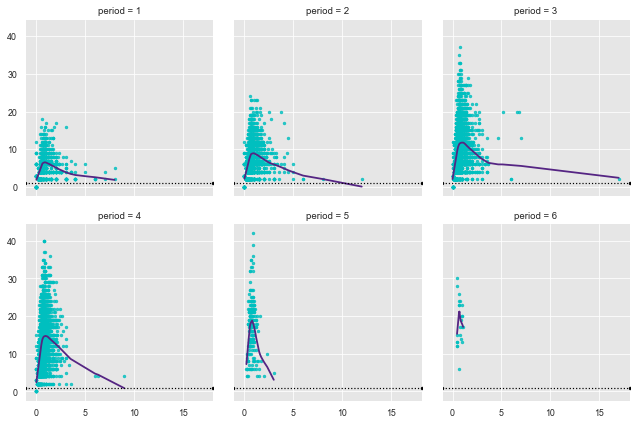

In [334]:
g = sns.lmplot('fg_pct', 'pts', col='period', data=kobe[kobe.period <=6].groupby(['season','period','pts','fg_pct'])['shot_id'].count().reset_index(),
               markers=".", scatter_kws=dict(color='c'),
              col_wrap=3, height=3, lowess=True)
g.map(plt.axhline, y=1, color="k", ls=":");

In [100]:
kobe.columns.unique()

Index(['action_type', 'arena_temp', 'attendance', 'avgnoisedb',
       'combined_shot_type', 'game_date', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'matchup', 'minutes_remaining', 'opponent',
       'period', 'playoffs', 'recId', 'season', 'seconds_remaining',
       'shot_distance', 'shot_id', 'shot_made_flag', 'shot_type',
       'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'team_id',
       'team_name', 'kobe_shot_loc', 'cum_shot_made', 'prior_shot_made', 'opp',
       'oppSeason', 'home_game', 'secondsFromPeriodEnd',
       'secondsFromPeriodStart', 'secondsFromGameStart', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'OBPM', 'PTS_rating', 'FGM_rating',
       'FGA_rating', 'FG%_rating', '3PM_rating', '3PA_rating', '3P%_rating',
       'WL', 'game_won', 'score_ratio', 'OppSeason', 'OppDefRank',
       'OppDef_Rating', 'Conf', 'Div', 'Same_Conf', 'Same_Div'

In [286]:
kobe.shot_made_flag.isnull()

0        False
1         True
2         True
3        False
4        False
5        False
6        False
7         True
8        False
9        False
10       False
11       False
12        True
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20        True
21        True
22       False
23       False
24        True
25        True
26       False
27       False
28       False
29       False
         ...  
25667     True
25668    False
25669    False
25670    False
25671    False
25672    False
25673    False
25674    False
25675    False
25676    False
25677     True
25678    False
25679    False
25680    False
25681    False
25682    False
25683     True
25684    False
25685    False
25686     True
25687    False
25688    False
25689     True
25690    False
25691    False
25692    False
25693    False
25694    False
25695    False
25696     True
Name: shot_made_flag, Length: 25697, dtype: bool

In [315]:
kobe.head(20)

,action_type,arena_temp,attendance,avgnoisedb,combined_shot_type,game_date,game_event_id,game_id,lat,loc_x,loc_y,lon,matchup,minutes_remaining,opponent,period,playoffs,recId,season,seconds_remaining,shot_distance,shot_id,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,kobe_shot_loc,cum_shot_made,prior_shot_made,opp,oppSeason,home_game,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,PTS,PER,TS%,3PAr,FTr,OBPM,PTS_rating,FGM_rating,FGA_rating,FG%_rating,3PM_rating,3PA_rating,3P%_rating,WL,game_won,score_ratio,OppSeason,OppDefRank,OppDef_Rating,Conf,Div,Same_Conf,Same_Div,Opp_margin_of_victory,LAL_Season,LA_mov,LA_offRating,net_la_v_oppd_rating,top_rated,hot_hand,pts,field_goal_attempts,field_goal,fg_pct,three_pt_attempts,three_pt,three_pct
0,Jump Shot,69,14707,94.060,Jump Shot,36830,12,20000012,34.044,-157,0,-118.427,LAL @ POR,10,POR,1,0,1,2000-01,22,15,2,0.000,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,1.000,0.000,0.000,POR,POR2000-01,0,622,98,98,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,W,1,10,POR2001,8,102.210,W,P,1,1,4.200,LAL2001,3.380,109.330,7.120,1,nil,0.000,1.000,0.000,0.000,0.000,0.000,0.000
1,Jump Shot,69,14707,94.060,Jump Shot,36830,35,20000012,33.909,-101,135,-118.371,LAL @ POR,7,POR,1,0,2,2000-01,45,16,3,nan,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,1.000,0.000,0.000,POR,POR2000-01,0,465,255,255,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,W,1,10,POR2001,8,102.210,W,P,1,1,4.200,LAL2001,3.380,109.330,7.120,1,nil,0.000,1.000,0.000,0.000,0.000,0.000,0.000
2,Jump Shot,69,14707,94.060,Jump Shot,36830,43,20000012,33.869,138,175,-118.132,LAL @ POR,6,POR,1,0,3,2000-01,52,22,4,nan,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,1.000,0.000,0.000,POR,POR2000-01,0,412,308,308,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,W,1,10,POR2001,8,102.210,W,P,1,1,4.200,LAL2001,3.380,109.330,7.120,1,nil,0.000,1.000,0.000,0.000,0.000,0.000,0.000
3,Driving Dunk Shot,69,14707,94.060,Dunk,36830,155,20000012,34.044,0,0,-118.270,LAL @ POR,6,POR,2,0,4,2000-01,19,0,5,1.000,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,1.000,1.000,0.000,POR,POR2000-01,0,379,341,1061,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,W,1,10,POR2001,8,102.210,W,P,1,1,4.200,LAL2001,3.380,109.330,7.120,1,heat,2.000,2.000,1.000,0.500,0.000,0.000,0.000
4,Jump Shot,69,14707,94.060,Jump Shot,36830,244,20000012,34.055,-145,-11,-118.415,LAL @ POR,9,POR,3,0,5,2000-01,32,14,6,0.000,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,1.000,0.000,1.000,POR,POR2000-01,0,572,148,1588,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,W,1,10,POR2001,8,102.210,W,P,1,1,4.200,LAL2001,3.380,109.330,7.120,1,nil,2.000,3.000,1.000,0.333,0.000,0.000,0.000
5,Layup Shot,69,14707,94.060,Layup,36830,251,20000012,34.044,0,0,-118.270,LAL @ POR,8,POR,3,0,6,2000-01,52,0,7,1.000,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,1.000,1.000,0.000,POR,POR2000-01,0,532,188,1628,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,W,1,10,POR2001,8,102.210,W,P,1,1,4.200,LAL2001,3.380,109.330,7.120,1,heat,4.000,4.000,2.000,0.500,0.000,0.000,0.000
6,Jump Shot,69,14707,94.060,Jump Shot,36830,265,20000012,33.936,-65,108,-118.335,LAL @ POR,6,POR,3,0,7,2000-01,1

##### Encodings

We will start by iniializing 3 label encoders, below are the labels and the current unique categories.

* shot_zone_range: '8-16 ft.', '16-24 ft.', 'Less Than 8 ft.', '24+ ft.','Back Court Shot'
* shot_type : '2PT Field Goal', '3PT Field Goal'
* shot_zone_basic: 'Mid-Range', 'Restricted Area', 'In The Paint (Non-RA)','Above the Break 3', 'Right Corner 3', 'Backcourt', 'Left Corner 3'

In [54]:
from sklearn.preprocessing import LabelEncoder

le_shot_zone_range = LabelEncoder()
le_shot_type = LabelEncoder()
le_shot_zone_basic = LabelEncoder()

kobe['range_encoded'] = le_shot_zone_range.fit_transform(kobe.shot_zone_range)
kobe['type_encoded'] = le_shot_type.fit_transform(kobe.shot_type)
kobe['basic_encoded'] = le_shot_zone_basic.fit_transform(kobe.shot_zone_basic)

dummy variables

In [317]:
kobe = pd.concat([kobe, pd.get_dummies(kobe[['hot_hand']])], axis=1)

In [319]:
kobe.to_csv("./data/kobe_data2.csv")

### Correlation Analysis

In [335]:
# df_train comes form the 'flag = train' flag in the dataset.
train_corr = kobe[~kobe.shot_made_flag.isnull()].corr()
#kobe_corr['shot_made_flag'].sort_values(ascending=False)

train_correlation_target = abs(train_corr.shot_made_flag)
corr_matrix = train_correlation_target[train_correlation_target>0.05]
potentialFeatures=list(corr_matrix)

In [336]:
train_correlation_target.sort_values(ascending=False)

hot_hand_nil           1.000
shot_made_flag         1.000
hot_hand_heat          0.912
cum_shot_made          0.779
hot_hand_hot hand      0.242
shot_distance          0.196
pts                    0.148
loc_y                  0.147
lat                    0.147
fg_pct                 0.120
three_pct              0.100
attendance             0.090
prior_shot_made        0.070
score_ratio            0.069
kobe_shot_loc          0.067
three_pt               0.065
three_pt_attempts      0.061
game_won               0.060
avgnoisedb             0.051
FG%                    0.043
2P%                    0.043
eFG%                   0.042
arena_temp             0.041
field_goal             0.040
TS%                    0.039
LA_offRating           0.035
game_event_id          0.034
top_rated              0.033
secondsFromGameStart   0.032
LA_mov                 0.031
                        ... 
minutes_remaining      0.025
seconds_remaining      0.024
3PAr                   0.024
FG            

In [337]:
# create a function for plotting a dataframe with string columns and numeric values

def plot_dataframe(df, y_label):
    color='coral'
    fig = plt.gcf()
    fig.set_size_inches(20,12)
    plt.ylabel(y_label)
    
    ax = df.correlation.plot(linewidth=3.3, color=color)
    ax.set_xticks(df.index)
    ax.set_xticklabels(df.attributes, rotation=75); #Notice the ; (remove it and see what happens !)
    plt.show()

In [338]:
kobe.head(20)

,action_type,arena_temp,attendance,avgnoisedb,combined_shot_type,game_date,game_event_id,game_id,lat,loc_x,loc_y,lon,matchup,minutes_remaining,opponent,period,playoffs,recId,season,seconds_remaining,shot_distance,shot_id,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,kobe_shot_loc,cum_shot_made,prior_shot_made,opp,oppSeason,home_game,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,PTS,PER,TS%,3PAr,FTr,OBPM,PTS_rating,FGM_rating,FGA_rating,FG%_rating,3PM_rating,3PA_rating,3P%_rating,WL,game_won,score_ratio,OppSeason,OppDefRank,OppDef_Rating,Conf,Div,Same_Conf,Same_Div,Opp_margin_of_victory,LAL_Season,LA_mov,LA_offRating,net_la_v_oppd_rating,top_rated,hot_hand,pts,field_goal_attempts,field_goal,fg_pct,three_pt_attempts,three_pt,three_pct,hot_hand_heat,hot_hand_hot hand,hot_hand_nil
0,Jump Shot,69,14707,94.060,Jump Shot,36830,12,20000012,34.044,-157,0,-118.427,LAL @ POR,10,POR,1,0,1,2000-01,22,15,2,0.000,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,1.000,0.000,0.000,POR,POR2000-01,0,622,98,98,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,W,1,10,POR2001,8,102.210,W,P,1,1,4.200,LAL2001,3.380,109.330,7.120,1,nil,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0,0,1
1,Jump Shot,69,14707,94.060,Jump Shot,36830,35,20000012,33.909,-101,135,-118.371,LAL @ POR,7,POR,1,0,2,2000-01,45,16,3,nan,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,1.000,0.000,0.000,POR,POR2000-01,0,465,255,255,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,W,1,10,POR2001,8,102.210,W,P,1,1,4.200,LAL2001,3.380,109.330,7.120,1,nil,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0,0,1
2,Jump Shot,69,14707,94.060,Jump Shot,36830,43,20000012,33.869,138,175,-118.132,LAL @ POR,6,POR,1,0,3,2000-01,52,22,4,nan,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,1.000,0.000,0.000,POR,POR2000-01,0,412,308,308,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,W,1,10,POR2001,8,102.210,W,P,1,1,4.200,LAL2001,3.380,109.330,7.120,1,nil,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0,0,1
3,Driving Dunk Shot,69,14707,94.060,Dunk,36830,155,20000012,34.044,0,0,-118.270,LAL @ POR,6,POR,2,0,4,2000-01,19,0,5,1.000,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,1.000,1.000,0.000,POR,POR2000-01,0,379,341,1061,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,W,1,10,POR2001,8,102.210,W,P,1,1,4.200,LAL2001,3.380,109.330,7.120,1,heat,2.000,2.000,1.000,0.500,0.000,0.000,0.000,1,0,0
4,Jump Shot,69,14707,94.060,Jump Shot,36830,244,20000012,34.055,-145,-11,-118.415,LAL @ POR,9,POR,3,0,5,2000-01,32,14,6,0.000,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,1.000,0.000,1.000,POR,POR2000-01,0,572,148,1588,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,W,1,10,POR2001,8,102.210,W,P,1,1,4.200,LAL2001,3.380,109.330,7.120,1,nil,2.000,3.000,1.000,0.333,0.000,0.000,0.000,0,0,1
5,Layup Shot,69,14707,94.060,Layup,36830,251,20000012,34.044,0,0,-118.270,LAL @ POR,8,POR,3,0,6,2000-01,52,0,7,1.000,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,1.000,1.000,0.000,POR,POR2000-01,0,532,188,1628,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,W,1,10,POR2001,8,102.210,W,P,1,1,4.200,LAL2001,3.380,109.330,7.120,1,heat,4.000,4.000,2.000,0.500,0.000,0.000,0.000,1,0,0
6,Jump Shot,69,14707,94.060,Jum

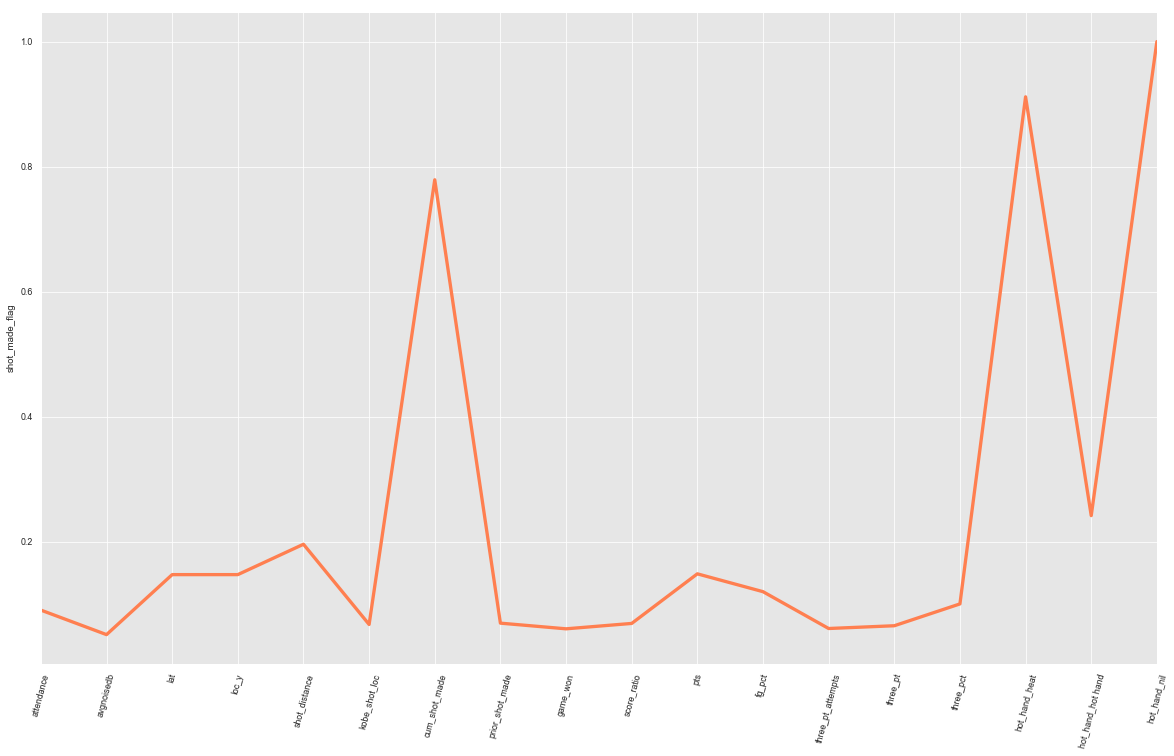

,attributes,correlation
17,hot_hand_nil,1.000
15,hot_hand_heat,0.912
6,cum_shot_made,0.779
16,hot_hand_hot hand,0.242
4,shot_distance,0.196
10,pts,0.148
3,loc_y,0.147
2,lat,0.147
11,fg_pct,0.120
14,three_pct,0.100


In [339]:
# create a dataframe suing cols and correlations
corr_matrix_ = corr_matrix[~corr_matrix.index.isin(['shot_made_flag'])]

df5 = pd.DataFrame({'attributes': corr_matrix_.index, 'correlation': corr_matrix_.values})

# lets plot above dataframe using the function we created

plot_dataframe(df5, 'shot_made_flag')
df5.sort_values('correlation',ascending=False)

As we can see, from the highly correlated features from above, there are only 3 new variables htat are above .1 which are `fg_pct`, `cum_shot_made` and `pts`

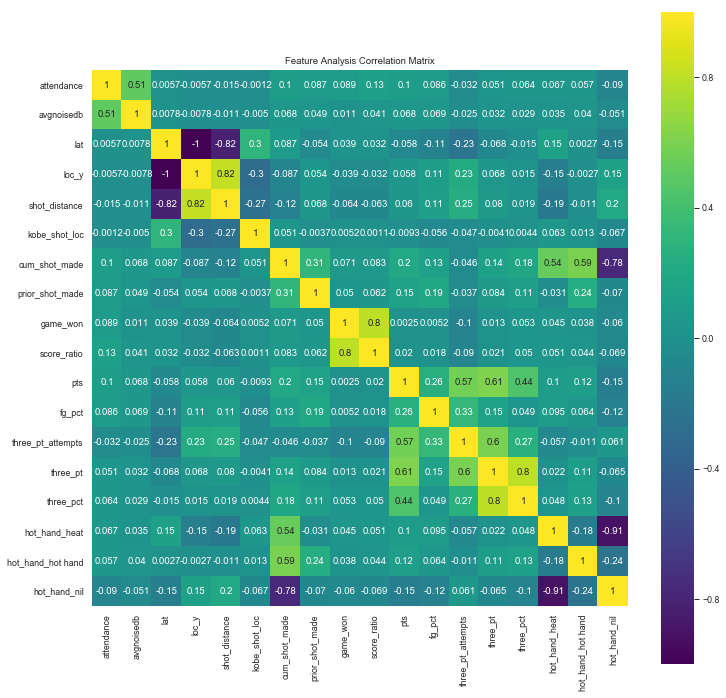

In [340]:

corr_matrix = kobe[~kobe.shot_made_flag.isnull()][list(corr_matrix_.index)].corr()

plt.figure(figsize=(12,12))
ax= plt.axes()
sns.heatmap(corr_matrix, vmax=1, square=True, annot=True, cmap='viridis', ax=ax)
ax.set_title('Feature Analysis Correlation Matrix')
plt.show()

#### Multicoliniarity

VIF

In [341]:
#https://etav.github.io/python/vif_factor_python.html
from statsmodels.stats.outliers_influence import variance_inflation_factor
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(corr_matrix.values, i) for i in range(corr_matrix.shape[1])]
vif["features"] = corr_matrix.columns
print("Variance Inflation Factor for Heatmap Predictors")
vif.round(1)

Variance Inflation Factor for Heatmap Predictors


,VIF Factor,features
0,2779222.800,attendance
1,580354.000,avgnoisedb
2,3002399751580330.500,lat
3,4503599627370496.000,loc_y
4,907159.900,shot_distance
5,938256.700,kobe_shot_loc
6,50098692.600,cum_shot_made
7,162917110.300,prior_shot_made
8,30371.600,game_won
9,1417447.900,score_ratio


In [342]:
corr_matrix

,attendance,avgnoisedb,lat,loc_y,shot_distance,kobe_shot_loc,cum_shot_made,prior_shot_made,game_won,score_ratio,pts,fg_pct,three_pt_attempts,three_pt,three_pct,hot_hand_heat,hot_hand_hot hand,hot_hand_nil
attendance,1.000,0.513,0.006,-0.006,-0.015,-0.001,0.104,0.087,0.089,0.128,0.102,0.086,-0.032,0.051,0.064,0.067,0.057,-0.090
avgnoisedb,0.513,1.000,0.008,-0.008,-0.011,-0.005,0.068,0.049,0.011,0.041,0.068,0.069,-0.025,0.032,0.029,0.035,0.040,-0.051
lat,0.006,0.008,1.000,-1.000,-0.818,0.304,0.087,-0.054,0.039,0.032,-0.058,-0.108,-0.226,-0.068,-0.015,0.148,0.003,-0.147
loc_y,-0.006,-0.008,-1.000,1.000,0.818,-0.304,-0.087,0.054,-0.039,-0.032,0.058,0.108,0.226,0.068,0.015,-0.148,-0.003,0.147
shot_distance,-0.015,-0.011,-0.818,0.818,1.000,-0.265,-0.118,0.068,-0.064,-0.063,0.060,0.113,0.249,0.080,0.019,-0.194,-0.011,0.196
kobe_shot_loc,-0.001,-0.005,0.304,-0.304,-0.265,1.000,0.051,-0.004,0.005,0.001,-0.009,-0.056,-0.047,-0.004,0.004,0.063,0.013,-0.067
cum_shot_made,0.104,0.068,0.087,-0.087,-0.118,0.051,1.000,0.311,0.071,0.083,0.196,0.126,-0.046,0.138,0.180,0.538,0.595,-0.779
prior_shot_made,0.087,0.049,-0.054,0.054,0.068,-0.004,0.311,1.000,0.050,0.062,0.152,0.190,-0.037,0.084,0.113,-0.031,0.239,-0.070
game_won,0.089,0.011,0.039,-0.039,-0.064,0.005,0.071,0.050,1.000,0.798,0.003,0.005,-0.100,0.013,0.053,0.045,0.038,-0.060
score_ratio,0.128,0.041,0.032,-0.032,-0.063,0.001,0.083,0.062,0.798,1.000,0.020,0.018,-0.090,0.021,0.050,0.051,0.044,-0.069


In [365]:

potentialFeatures = [
 'shot_distance', 'game_won','score_ratio',
 'pts','kobe_shot_loc','cum_shot_made',
 'fg_pct','attendance',
 'three_pct', 'top_rated']


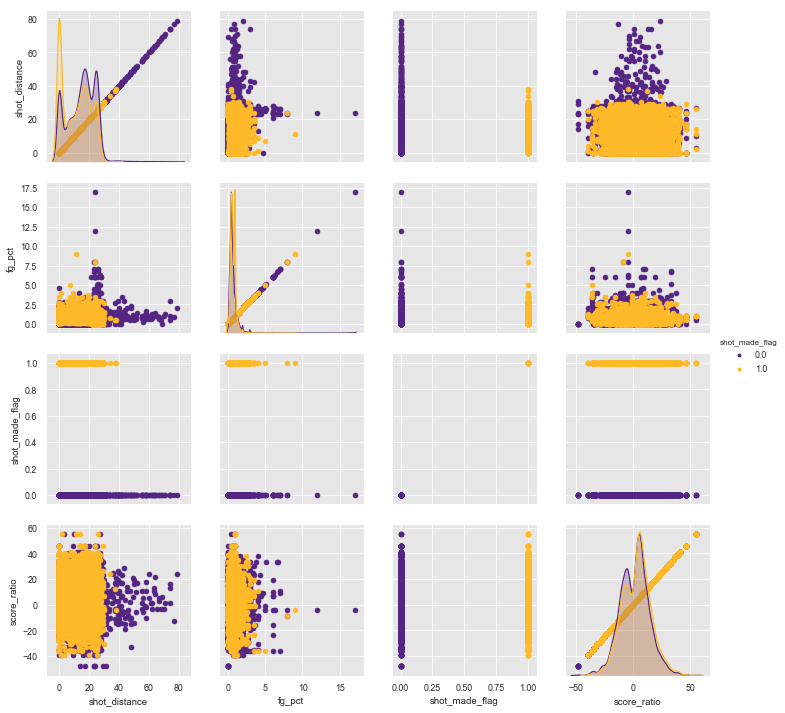

In [347]:
g = sns.pairplot(kobe[['shot_distance','fg_pct','shot_made_flag','score_ratio']], hue='shot_made_flag',
                diag_kind="kde", height=2.5, )
g.map(plt.scatter);

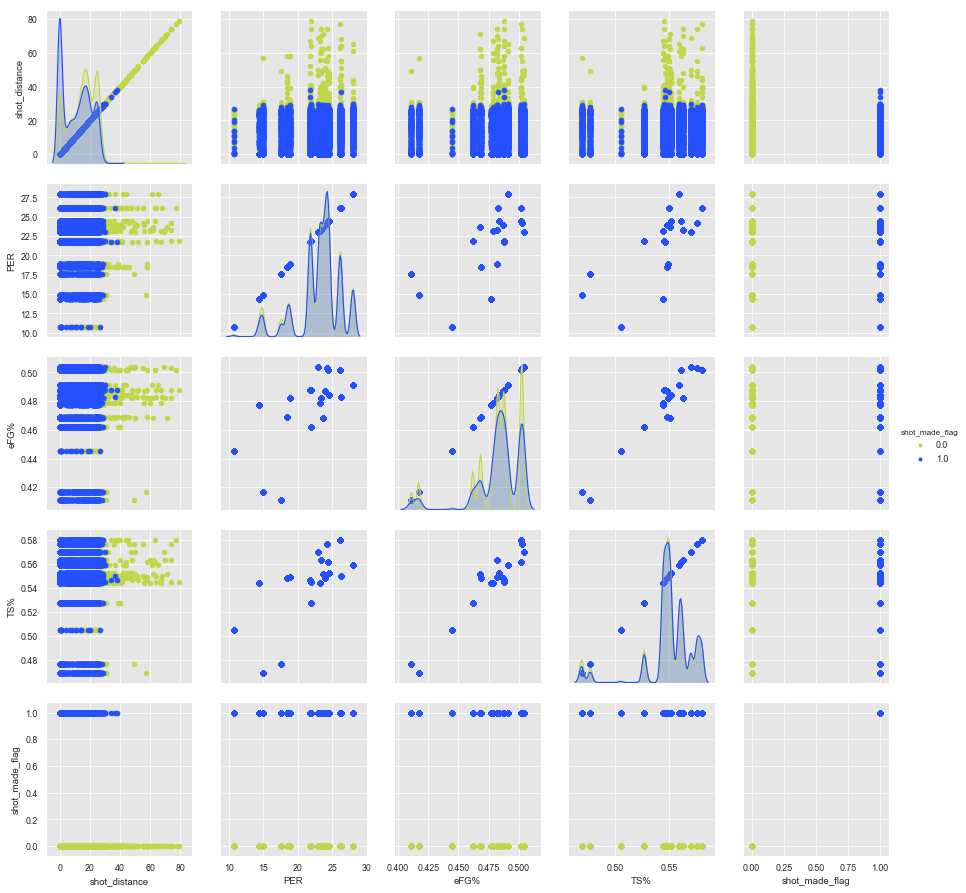

In [83]:
g = sns.pairplot(kobe[['shot_distance','PER','eFG%','TS%','shot_made_flag']], hue='shot_made_flag',
                diag_kind="kde", height=2.5, )
g.map(plt.scatter);

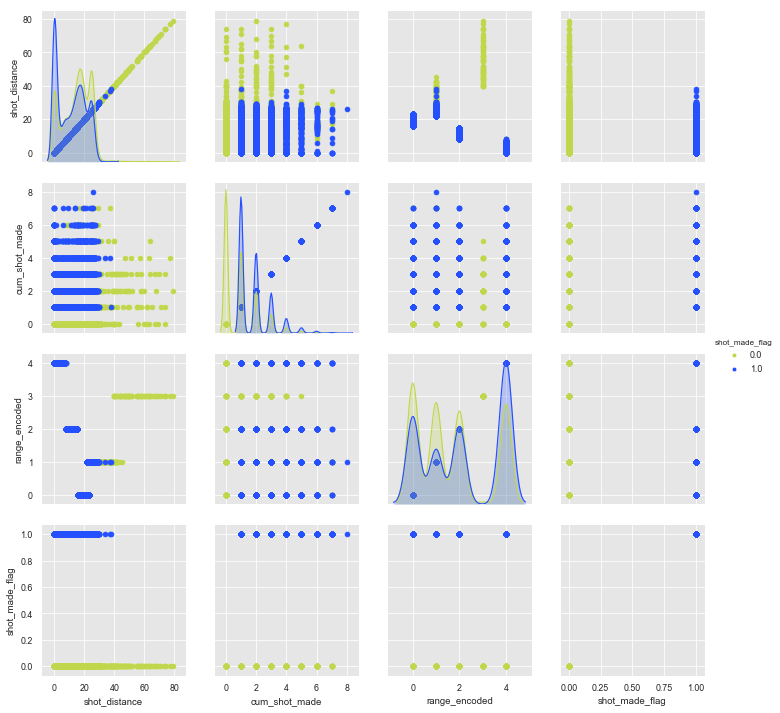

In [84]:
g = sns.pairplot(kobe[['shot_distance','cum_shot_made','range_encoded','shot_made_flag']], hue='shot_made_flag',
                diag_kind="kde", height=2.5, )
g.map(plt.scatter);

Create a graph to plot top features to show importance

In [366]:
def plot_feature_importances_playoffs(model):
    plt.figure(figsize=(10,5))
    importance = model.feature_importances_
    importance = -np.sort(-importance)
    n_features = len(importance[:20])
    plt.barh(range(n_features), importance[:20], align='center')
    plt.yticks(np.arange(n_features), X)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

## Modeling

![](https://images.performgroup.com/di/library/NBA_Global_CMS_image_storage/57/1e/kobe40kb-statsjpg_glcsz6la4tmy12tppmmhnj1lg.jpg?t=1566641621&w=1080&quality=80)
[_(Getty Images)_](read://www.sportingnews.com/?url=https%3A%2F%2Fwww.sportingnews.com%2Fau%2Fnba%2Fnews%2Fkobe-bryant-birthday-40-stats-los-angeles-lakers%2F1h14i3wsgajrv1jrlmandv4kza)

Great!! Now lets get to modeling! 

In [367]:
# y includes our labels (wins and losses) and x includes our features
y = kobe[~kobe.shot_made_flag.isnull()].shot_made_flag
X = kobe[~kobe.shot_made_flag.isnull()][potentialFeatures]

# test train split
from sklearn.model_selection import train_test_split

# split data train 70% and test 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


### Logistic Regression Model

Accuracy on training set: 1.000
Accuracy on test set: 1.000
Feature Importance: 
 None

Classification Report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3381
         1.0       1.00      1.00      1.00      2829

   micro avg       1.00      1.00      1.00      6210
   macro avg       1.00      1.00      1.00      6210
weighted avg       1.00      1.00      1.00      6210



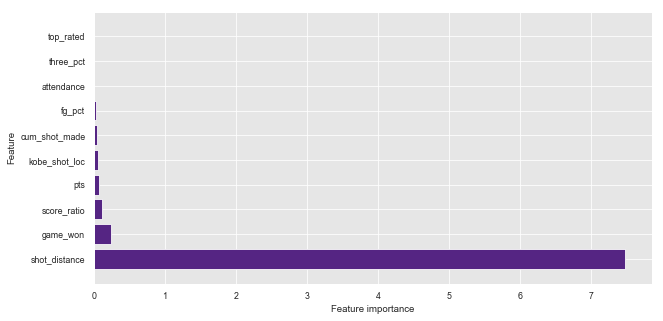

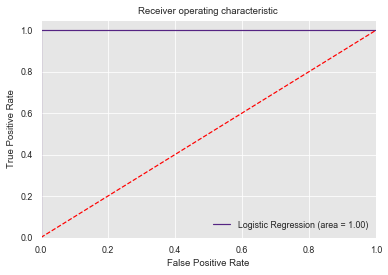

In [368]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

Y_pred = logreg.predict(X_test)

print("Accuracy on training set: {:.3f}".format(accuracy_score(y_train,logreg.predict(X_train))))
print("Accuracy on test set: {:.3f}".format(accuracy_score(y_test,logreg.predict(X_test))))

# create object for feature importance map
# https://stackoverflow.com/questions/51462979/how-to-get-feature-importance-in-logistic-regression-using-weights
weights = logreg.coef_
abs_weights = np.abs(weights)
logreg.feature_importances_ = abs_weights[0]
print("Feature Importance: \n",plot_feature_importances_playoffs(logreg))
print("\nClassification Report")
print(classification_report(y_test, logreg.predict(X_test)))


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

rf_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

plt.figure()
#plt.plot(fpr, tpr, label='GradientBoosting (area = %0.2f)' % gb_roc_auc)
plt.plot(rf_fpr, rf_tpr, label='Logistic Regression (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('ROC')
plt.show()

More details on sklearn metrics - 
* [percision recall fscore support](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support)

In [369]:
logreg100 = LogisticRegression(C=900).fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg100.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg100.score(X_test, y_test)))

Training set score: 1.000
Test set score: 1.000


In [370]:
logreg001 = LogisticRegression(C=0.01).fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg001.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg001.score(X_test, y_test)))

Training set score: 1.000
Test set score: 1.000


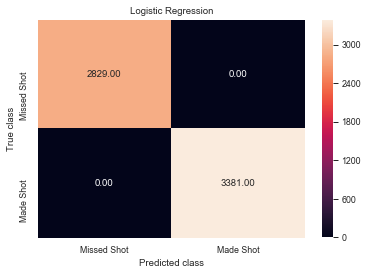

In [371]:
logreg_y_pred = logreg100.predict(X_test)
logreg_cm = metrics.confusion_matrix(logreg_y_pred, y_test, [1,0])
sns.heatmap(logreg_cm, annot=True, fmt='.2f',xticklabels = ["Missed Shot", "Made Shot"] , yticklabels = ["Missed Shot", "Made Shot"])
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Logistic Regression')
plt.savefig('logistic_regression')

__Linear Discriminate Analysis:__

In [372]:
# https://blog.eduonix.com/artificial-intelligence/linear-discriminant-analysis-with-scikit-learn/

# load up preprocessing
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
kobe_features = sc.fit_transform(X)

Accuracy of LDA classifier on training set: 0.97
Accuracy of LDA classifier on test set: 0.96
Feature Importance: 
 None


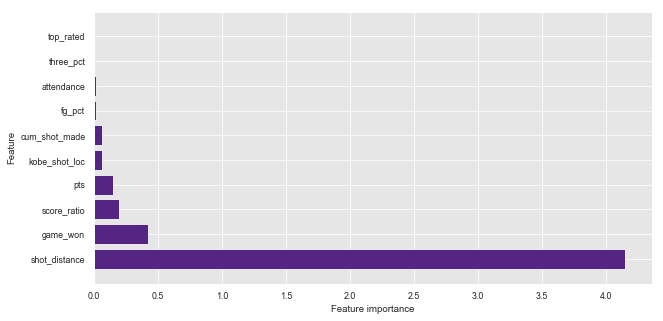

In [373]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'.format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'.format(lda.score(X_test, y_test)))


weights = lda.coef_
abs_weights = np.abs(weights)
lda.feature_importances_ = abs_weights[0]
print("Feature Importance: \n",plot_feature_importances_playoffs(lda))

#### Suppoert Vector Machine

In [374]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(accuracy_score(y_train, svc.predict(X_train))))
print("Accuracy on test set: {:.3f}".format(accuracy_score(y_test, svc.predict(X_test))))

Accuracy on training set: 0.968
Accuracy on test set: 0.538


In [375]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

svc = SVC()
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 1.00


In [376]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
    svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 1.000


#### GradientBoostingClassifier

Accuracy on training set: 0.856
Accuracy on test set: 0.851
Feature Importance: 
 None


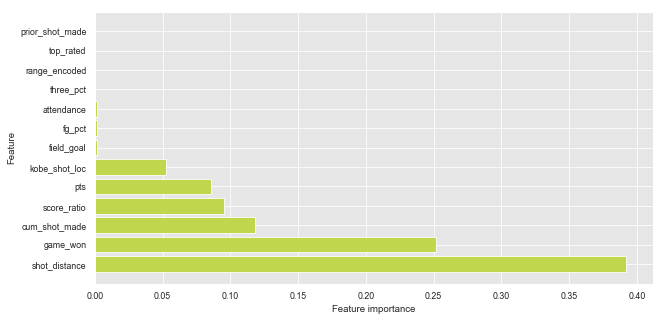

In [112]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gb.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb.score(X_test, y_test)))
print("Feature Importance: \n",plot_feature_importances_playoffs(gb))

Accuracy on training set: 0.816
Accuracy on test set: 0.818
Feature Importance: 
 None


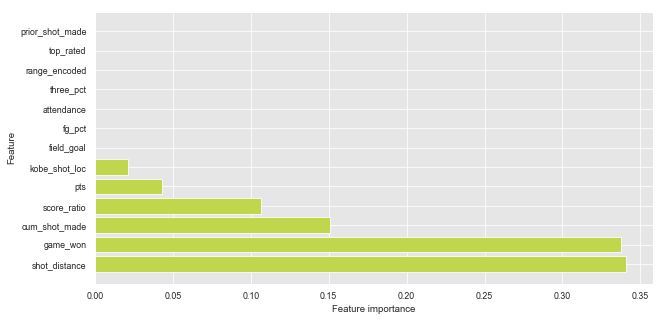

In [113]:
gb2 = GradientBoostingClassifier(random_state=0, max_depth=1)
gb2.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gb2.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gb2.score(X_test, y_test)))
print("Feature Importance: \n",plot_feature_importances_playoffs(gb2))

__Random Forest Classifier__

Accuracy on training set: 0.994
Accuracy on test set: 0.832


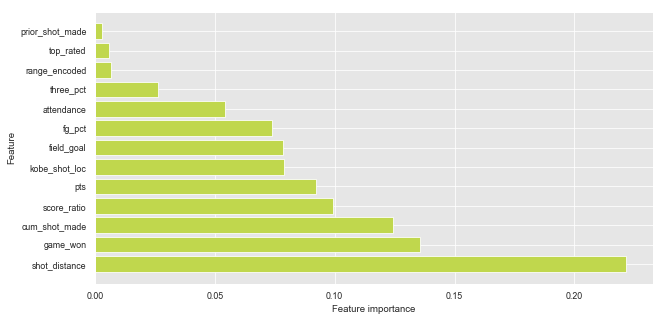

In [114]:
from sklearn.ensemble import RandomForestClassifier

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(X_train,y_train)

print("Accuracy on training set: {:.3f}".format(accuracy_score(y_train,clf_rf.predict(X_train))))
print("Accuracy on test set: {:.3f}".format(accuracy_score(y_test,clf_rf.predict(X_test))))
plot_feature_importances_playoffs(clr_rf)

### Evaluation

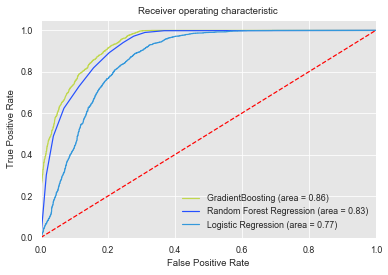

In [115]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

gb_roc_auc = roc_auc_score(y_test, gb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, gb.predict_proba(X_test)[:,1])

rf_roc_auc = roc_auc_score(y_test, clf_rf.predict(X_test))
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, clf_rf.predict_proba(X_test)[:,1])

logt_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
logt_fpr, logt_tpr, logt_thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='GradientBoosting (area = %0.2f)' % gb_roc_auc)
plt.plot(rf_fpr, rf_tpr, label='Random Forest Regression (area = %0.2f)' % rf_roc_auc)
plt.plot(logt_fpr, logt_tpr, label='Logistic Regression (area = %0.2f)' % logt_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('ROC')
plt.show()

In [127]:
kobe[kobe.game_id==29600781]

,action_type,arena_temp,attendance,avgnoisedb,combined_shot_type,game_date,game_event_id,game_id,lat,loc_x,loc_y,lon,matchup,minutes_remaining,opponent,period,playoffs,recId,season,seconds_remaining,shot_distance,shot_id,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,prior_shot_made,cum_shot_made,opp,oppSeason,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,PTS,PER,TS%,3PAr,FTr,OBPM,hot_hand,pts,field_goal_attempts,field_goal,fg_pct,three_pt_attempts,three_pt,three_pct,PTS_rating,FGM_rating,FGA_rating,FG%_rating,3PM_rating,3PA_rating,3P%_rating
24510,Jump Shot,67,11699,95.830,Jump Shot,35484,110,29600781,33.852,110,192,-118.160,LAL vs. NYK,10,NYK,2,0,23149,1996-97,56,22,23150,nan,3PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,0.000,nan,NYK,NYK1996-97,2.500,5.900,0.417,0.700,1.900,0.375,1.800,4.000,0.437,0.477,1.900,2.300,0.819,7.600,14.400,0.544,0.322,0.393,-0.900,None,nan,0.000,0.000,0.000,1.000,0.000,0.000,118,128,121,500,74,81,500
24511,Jump Shot,67,11699,95.830,Jump Shot,35484,114,29600781,33.919,-127,125,-118.397,LAL vs. NYK,10,NYK,2,0,23150,1996-97,26,17,23151,nan,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,1.000,nan,NYK,NYK1996-97,2.500,5.900,0.417,0.700,1.900,0.375,1.800,4.000,0.437,0.477,1.900,2.300,0.819,7.600,14.400,0.544,0.322,0.393,-0.900,None,nan,1.000,0.000,0.000,1.000,0.000,0.000,118,128,121,500,74,81,500


In [122]:
kobe.hot_hand.values[:4]

array(['avg', 'avg', 'avg', 'avg'], dtype=object)

## Kobe - Lord of the Rings 

![](https://s-media-cache-ak0.pinimg.com/originals/7d/09/10/7d091006c1a06f2c9df1ad4ada47cd3e.jpg)

----
# Objective 2 - Shot Distance Probability and Association

Recall Objective 2:
2. Build models to provide arguments and evidence for or against the propositions below. For Each Quanitfy your findings with statistical evidence _(Test, CI, plots, etc.)_
    * 2.1. The odds of Kobe making a shot decreases with respect to the distance he is from the hoop.
    * 2.2. The probability of Kobe making a shot decreases linearly with respects to the distacne he is from the hoop.
    * 2.3. The relationship between the distance Kobe is from te basket and the odds of him making the shot is different if they are in the playoffs.

To perform this analysis we will need to analyze the dataset from the `shot_zone_range`. Which include the following categories and distribution over shots made and missed.

['8-16 ft.' '16-24 ft.' 'Less Than 8 ft.' '24+ ft.' 'Back Court Shot']


Text(0.5, 1.0, 'Kobe Shot Zone Range Distribution on Shots Made/Missed')

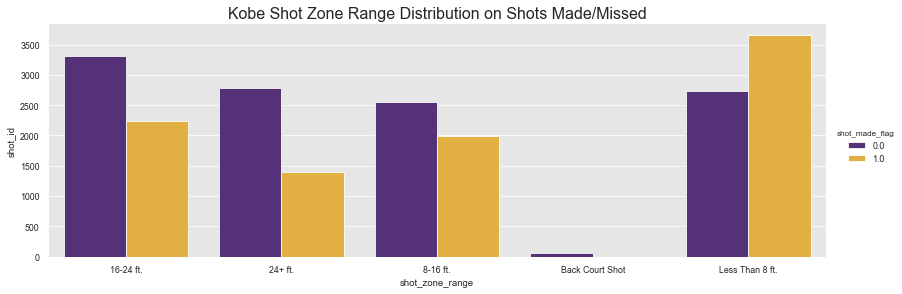

In [332]:
print(kobe.shot_zone_range.unique())
sns.catplot(x='shot_zone_range', y='shot_id',
            hue='shot_made_flag', kind='bar', height=4, aspect=11.7/4,
           data=kobe.groupby(['shot_zone_range','shot_made_flag'])['shot_id'].count().reset_index())
plt.title("Kobe Shot Zone Range Distribution on Shots Made/Missed", fontsize=16)

Utilizing this data, we prepare a 2 x 4 crosstabulation table taken from the train data set to determine the __(1) odds, (2) proportion and (3) relationship between Kobe making a shot and distance from the basket__. 

In [75]:
shotrange = pd.crosstab(train.shot_made_flag, 
                                        train.shot_zone_range).sort_values('shot_made_flag', ascending=False) #[['16-24 ft.','8-16 ft.','Less Than 8 ft.']]
shot_range = sm.stats.Table(shotrange)
shot_range.table_orig

shot_zone_range,16-24 ft.,24+ ft.,8-16 ft.,Back Court Shot,Less Than 8 ft.
shot_made_flag,,,,,
1,2236,1394,1983,0,3653
0,3305,2780,2555,60,2731


In [76]:
kobe.shot_distance.head()

0    15
1     0
2    14
3     0
4    12
Name: shot_distance, dtype: int64

In [218]:
part2 = kobe[['shot_distance', 'shot_made_flag']].corr()
part2['shot_made_flag'].sort_values(ascending=False)

shot_made_flag    1.000
shot_distance    -0.196
Name: shot_made_flag, dtype: float64

Below is a `SAS` output of hte _Cochran-Mantel-Haenszel_ table output for our review the linear relationship between `shot_distance` and `shot_made`. We can see the $\chi^2 = 713.0227$ for the row mean score difference, and simisimilarly to the _General Association_ score. Moreover the _nonzero Correlation_ value is nearly 500. All test provided significant evidence this correlation test is highly significant

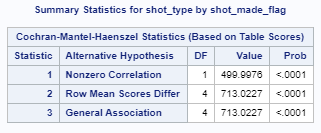

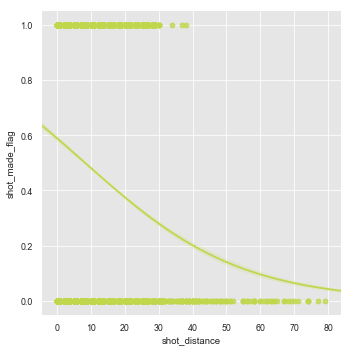

In [77]:
# shot probability as a function of shot distance
sns.lmplot(x="shot_distance", y="shot_made_flag", data = kobe,  y_jitter=.02, logistic=True)

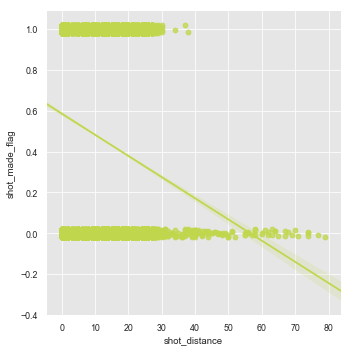

In [214]:
# shot probability as a function of shot distance
sns.lmplot(x="shot_distance", y="shot_made_flag", data = kobe,  y_jitter=.02, logistic=False)

#### Chi-squared Independence Test

To start off, we will perfomr a $\chi^2$ independence test to determine whether Kobe's shots are independent of the shot range to gain a better understanding of the overall relationship between the two varaiables. 

To perform this calculation, we will perform two types of Independence test: (1) Pearson Chi-Squared test and (2) Likilhood Ratio Test. 

Test 1 is the test using __Perasrons's Chi-squared Statistic__, which is defined as:

$X^2=\sum\limits_{i=1}^I \sum\limits_{j=1}^J  \dfrac{(O_{ij}-E_{ij})^2}{E_{ij}}$



In [43]:
chi2, p, dof, ex = stats.chi2_contingency(shot_range.table)

print("Pearson's Chi-squared test with Yates' continuity correction")
print("X-squared: ", chi2)
print("p-value  : ", p)
print("degree of f: ", dof)

Pearson's Chi-squared test with Yates' continuity correction
X-squared:  711.9279234120621
p-value  :  9.108357067361717e-153
degree of f:  4


__Likelihood Ratio Chi-Square Test__

Test 2 is the test __Likelihood Ratio Chi-Squared Statistic__, which is defined as:

$G^2=2\sum\limits_{i=1}^I \sum\limits_{j=1}^J O_{ij}\text{log}\left(\dfrac{O_{ij}}{E_{ij}}\right)$

In [44]:
chi2, p, dof, ex = stats.chi2_contingency(shot_range.table, lambda_="log-likelihood", correction=False)
print("Likelihood ratio test")
print("G2 - Likelihood-ratio stat: ", chi2)
print("p-value  : ", p)
print("degree of f: ", dof)

Likelihood ratio test
G2 - Likelihood-ratio stat:  734.2791820999303
p-value  :  1.3161762333403974e-157
degree of f:  4


__Interpretation__ In review of the chi-square independence test we otained a $\chi^2 = 711.93$ and a likelihood squared statistic $G^2 = 734.28$, which both test provided a probability value of p-value < 0.001. Therefore, given the large $\chi^2$ statistics for the test of independence at a degree of freedom of 4, we conclude there is sufficient significant evidence to __reject the null hythoesis for independence indicating a relationship existing between Kobe's shots and shot range__. 

#### Residuals Analysis based off the Independence Test
Since there is evidence of a relationship, we assess the residiuals to gain a beter understanding the degress and which variables are suggesting this lack of independence. We begin with calculating the Critical $\chi^2$ Value that uses the $\chi^2$ distribution table when providing the degrees of freedm and left side probability curve.

$X^2=\sum \dfrac{(n_{ij}-n\pi_{ij})^2}{n\pi_{ij}}$

In [45]:
stats.chi2.isf(q=0.05, df=4)

9.487729036781158

We have a Critical $\chi^2 = 9.49$ based on a 95% significance level. Next we calcualte the __Standardized Pearson residuals__ using the 9.49 at a threshold for anything greater will be identified as significant. 

In [46]:
shot_range.chi2_contribs

shot_zone_range,16-24 ft.,24+ ft.,8-16 ft.,Back Court Shot,Less Than 8 ft.
shot_made_flag,,,,,
1,24.135,120.550,1.165,26.319,221.021
0,19.565,97.723,0.944,21.336,179.169


__Interpretation:__ Reviewing the above Standardized Pearson residuals based on the $\chi^2$ distribution found the following `shot_zone_range`'s to have overwhellming evidence of statistical significance as the residuals are greater than the Critical $\chi^2 = 9.49$, `16-24 ft.`, `24+ft.`, `Back Court Shot`, `Less Than 8ft.`. Moreover, it appears that `24+ft` and `less Than 8ft` resulted in the highest residuals indicate these are key variables suggesting Kobe's `shote_made` and `shot_zone_range` are associated. 

### Odds Ratio and Difference in proportions

Now that we have rejected the null hypothesis for independence, the next step is to measure the magnitude of the relationshiop between `shot_made_flag` and `shot_zone_range`. To do this we will utilize two different measures of associations:
1. __differnece in proportions__
2. __odds ratio__

__Partitioning and Odds Ratio__

Next we evaluate the __Odds Ratio__ which provides ratio statistics on the probability of sccess for a given conditional probaility. For each of the `shot_zone_range_` that was indicated to be related, we will evaluate the `Odds`  = $\theta$ of making the shot from a given range. To focus on the categorical variables into individual Odds Ratio test, we can determine the specific distance that are no related and are important for the overall finding for evaluating the probability if Kobe's shot decreases with respects to the distance. 

$\pi = \dfrac{odds}{(odds+1)}$

$odds_1=\dfrac{P(Z=1|Y=1)}{P(Z=2|Y=1)}=\dfrac{\pi_{1|1}}{\pi_{2|1}}=\dfrac{\pi_{1|1}}{1-\pi_{1|1}}$

`16-24ft vs 24+ft.` - $\hat{\theta}_{12}=\dfrac{2236\times 2780}{1394\times 3305}=1.349$

In [47]:
print("Effect prob 16-24 ft. vs 24+ ft.: ",round((shotrange['16-24 ft.'][1]*shotrange['24+ ft.'][0]) / 
                                           (shotrange['24+ ft.'][1]*shotrange['16-24 ft.'][0]),3))

print("Effect prob 16-24 ft. vs Less Than 8 ft.: ",round((shotrange['16-24 ft.'][1]*shotrange['Less Than 8 ft.'][0]) / 
                                           (shotrange['Less Than 8 ft.'][1]*shotrange['16-24 ft.'][0]),3))

print("Effect prob Less Than 8 ft. vs 16-24 ft.: ",round((shotrange['16-24 ft.'][0]*shotrange['Less Than 8 ft.'][1]) / 
                                           (shotrange['Less Than 8 ft.'][0]*shotrange['16-24 ft.'][1]),3))

#print("Effect prob 16-24 ft. vs Back Court Shot: ",round((shotrange['16-24 ft.'][0]*shotrange['Back Court Shot'][1]) /                                            (shotrange['Back Court Shot'][0]*shotrange['16-24 ft.'][1]),3))

#print("Effect prob 24+ ft. vs Back Court Shot: ",round((shotrange['24+ ft.'][0]*shotrange['Back Court Shot'][1]) /                                            (shotrange['Back Court Shot'][0]*shotrange['24+ ft.'][1]),3))

print("Effect prob 24+ ft. vs Less Than 8 ft.: ",round((shotrange['24+ ft.'][1]*shotrange['Less Than 8 ft.'][0]) / 
                                           (shotrange['Less Than 8 ft.'][1]*shotrange['24+ ft.'][0]),3))


print("Effect prob Less Than 8 ft. vs 24+ ft. : ",round((shotrange['24+ ft.'][0]*shotrange['Less Than 8 ft.'][1]) / 
                                           (shotrange['Less Than 8 ft.'][0]*shotrange['24+ ft.'][1]),3))

#print("Effect prob Back Court Shot vs Less Than 8 ft.: ",round((shotrange['Back Court Shot'][1]*shotrange['Less Than 8 ft.'][0]) /                                                               (shotrange['Less Than 8 ft.'][1]*shotrange['Back Court Shot'][0]),3))


Effect prob 16-24 ft. vs 24+ ft.:  1.349
Effect prob 16-24 ft. vs Less Than 8 ft.:  0.506
Effect prob Less Than 8 ft. vs 16-24 ft.:  1.977
Effect prob 24+ ft. vs Less Than 8 ft.:  0.375
Effect prob Less Than 8 ft. vs 24+ ft. :  2.668


__Interpretation - Odds Ratio:__ Above are the odds ratio estimates for the variables that were identified as related. We can conclude the following about Kobe's shots, based on the odds scale:
* Shots at `16-24ft.` are estimated to be __35% more likely to be a make__ than shots taken at `24+ ft.`.
* Shots at `16-24ft.` are estimated to be __51% less likely to be a make__ than shots taken at `Less than 8ft.`
* Shots at `24+ft.` are estimated to be __38% less likely to be a make__ than shots taken at `Less than 8ft.`

__Therefore we can conclude, Yes, Kobe's shot decreases the further out the shot is taken. More specifically, the shorter the shots are the more likely Kobe would make the shots.__, in which we found:

* Shots `Less than 8ft` are estimated to be __almost 2 times likely (98%) a make__ than shots taken at `16-24ft.`
* Shots `Less than 8ft` are estimate to be __over 2.5 time likely to make__ than shots takens at `24+ft.`


__Linear Association__

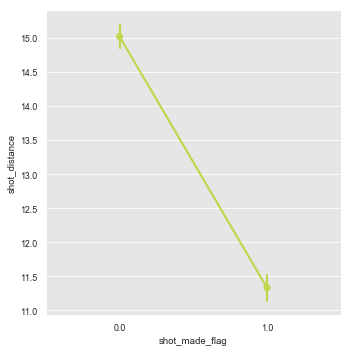

In [198]:
sns.catplot(x="shot_made_flag", y="shot_distance", kind="point", data=kobe);

KeyboardInterrupt: 

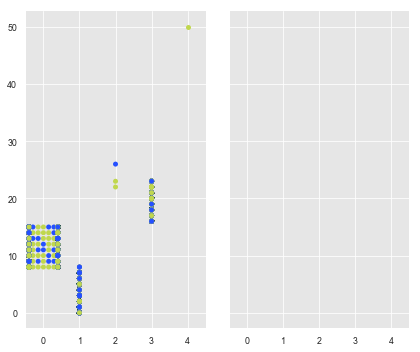

In [199]:


sns.catplot(x="shot_zone_range", y="shot_distance", hue="shot_made_flag",
            col="shot_type", aspect=.6,
            kind="swarm", data=kobe);

In [196]:
kobe.head()

,action_type,arena_temp,attendance,avgnoisedb,combined_shot_type,game_date,game_event_id,game_id,lat,loc_x,loc_y,lon,matchup,minutes_remaining,opponent,period,playoffs,recId,season,seconds_remaining,shot_distance,shot_id,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,prior_shot_made,cum_shot_made,opp,oppSeason,home_game,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,PTS,PER,TS%,3PAr,FTr,OBPM,PTS_rating,FGM_rating,FGA_rating,FG%_rating,3PM_rating,3PA_rating,3P%_rating,top_rated,hot_hand,pts,field_goal_attempts,field_goal,fg_pct,three_pt_attempts,three_pt,three_pct,range_encoded,type_encoded,basic_encoded,kobe_shot_loc
0,Jump Shot,69,14707,94.060,Jump Shot,36830,12,20000012,34.044,-157,0,-118.427,LAL @ POR,10,POR,1,0,1,2000-01,22,15,2,0.000,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,0.000,0.000,POR,POR2000-01,0,622,98,98,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,1,avg,0.000,1.000,0.000,0.000,0.000,0.000,0.000,2,0,4,1.000
1,Driving Dunk Shot,69,14707,94.060,Dunk,36830,155,20000012,34.044,0,0,-118.270,LAL @ POR,6,POR,2,0,4,2000-01,19,0,5,1.000,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,0.000,1.000,POR,POR2000-01,0,379,341,1061,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,1,avg,2.000,2.000,1.000,0.500,0.000,0.000,0.000,4,0,5,1.000
2,Jump Shot,69,14707,94.060,Jump Shot,36830,244,20000012,34.055,-145,-11,-118.415,LAL @ POR,9,POR,3,0,5,2000-01,32,14,6,0.000,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,0.000,0.000,POR,POR2000-01,0,572,148,1588,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,1,avg,0.000,3.000,1.000,0.333,0.000,0.000,0.000,2,0,4,1.000
3,Layup Shot,69,14707,94.060,Layup,36830,251,20000012,34.044,0,0,-118.270,LAL @ POR,8,POR,3,0,6,2000-01,52,0,7,1.000,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,0.000,1.000,POR,POR2000-01,0,532,188,1628,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,1,avg,2.000,4.000,2.000,0.500,0.000,0.000,0.000,4,0,5,1.000
4,Jump Shot,69,14707,94.060,Jump Shot,36830,265,20000012,33.936,-65,108,-118.335,LAL @ POR,6,POR,3,0,7,2000-01,12,12,9,1.000,2PT Field Goal,Left Side(L),In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,1.000,2.000,POR,POR2000-01,0,372,348,1788,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,1,heat,4.000,5.000,3.000,0.600,0.000,0.000,0.000,2,0,2,1.000


In [67]:
shot_range.table_orig

shot_zone_range,16-24 ft.,24+ ft.,8-16 ft.,Back Court Shot,Less Than 8 ft.
shot_made_flag,,,,,
1,2236,1394,1983,0,3653
0,3305,2780,2555,60,2731


In [73]:
short_v_midrange = sm.stats.Table2x2(shot_range.table_orig[['Less Than 8 ft.','8-16 ft.']].values)
short_v_farrange = sm.stats.Table2x2(shot_range.table_orig[['Less Than 8 ft.','16-24 ft.']].values)
short_v_deeeprange = sm.stats.Table2x2(shot_range.table_orig[['Less Than 8 ft.','24+ ft.']].values)

print("Less than 8tf. vs Midrange (8-16ft)")
print("Odds Ratio: ", short_v_midrange.oddsratio)
print("Confidence INterval: ", short_v_midrange.oddsratio_confint())

print("\nLess than 8tf. vs Far Range (16-24tf)")
print("Odds Ratio: ", short_v_farrange.oddsratio)
print("Confidence INterval: ", short_v_farrange.oddsratio_confint())

print("\nLess than 8tf. vs Deep Range (24+)")
print("Odds Ratio: ", short_v_deeeprange.oddsratio)
print("Confidence INterval: ", short_v_deeeprange.oddsratio_confint())

Less than 8tf. vs Midrange (8-16ft)
Odds Ratio:  1.7234399757883423
Confidence INterval:  (1.5960278559327132, 1.8610235022555515)

Less than 8tf. vs Far Range (16-24tf)
Odds Ratio:  1.9770954501715872
Confidence INterval:  (1.837789725950275, 2.126960644024703)

Less than 8tf. vs Deep Range (24+)
Odds Ratio:  2.6675341882115484
Confidence INterval:  (2.459456548275177, 2.8932158408196766)


__Interpretation - Odds Ratio:__ Above are the odds ratio estimates for the variables that were identified as related. We can conclude the following about Kobe's shots, based on the odds scale:
* Shots `Less than 8ft` are estimated to be __78% more likely to a make__ than shots taken at mid-range `8-16ft.`, with a 95% confidnece the odds ratio is between 1.60 and 1.86. 
* Shots `Less than 8ft` are estimated to be __almost 2 times likely (98%) a make__ than shots taken at `16-24ft.`, with a 95% confidnece the odds ratio is between 1.84 and 2.13. 
* Shots `Less than 8ft` are estimate to be __over 2.5 time likely to make__ than shots takens at `24+ft.`, with a 95% confidnece the odds ratio is between 2.46 and 2.89. 

__Therefore we can conclude, Yes, Kobe's shot decreases the further out the shot is taken. More specifically, the shorter the shots are the more likely Kobe would make the shots.__, Furthermore, each of the confidence intervals above did not contain 1, therefore, additional evidence is provided kobe's shot and shot distance are related. 



----
## 2.3 Kobe Shot Range vs Playoffs 

> Objective: The relationship between the distance Kobe is from te basket and the odds of him making the shot is different if they are in the playoffs.

To do this we will create a three way contingency table with the three categorical variables of `playoffs`, `shot_made_flag`, and `shot_zone_range`. 

In [187]:
shots_playoffs = pd.crosstab([train[train.playoffs==1].shot_zone_range], train.shot_made_flag).T
shots_seaon = pd.crosstab([train[train.playoffs==0].shot_zone_range], train.shot_made_flag).T

In [192]:
kobe.head()

,action_type,arena_temp,attendance,avgnoisedb,combined_shot_type,game_date,game_event_id,game_id,lat,loc_x,loc_y,lon,matchup,minutes_remaining,opponent,period,playoffs,recId,season,seconds_remaining,shot_distance,shot_id,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,prior_shot_made,cum_shot_made,opp,oppSeason,home_game,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,PTS,PER,TS%,3PAr,FTr,OBPM,PTS_rating,FGM_rating,FGA_rating,FG%_rating,3PM_rating,3PA_rating,3P%_rating,top_rated,hot_hand,pts,field_goal_attempts,field_goal,fg_pct,three_pt_attempts,three_pt,three_pct,range_encoded,type_encoded,basic_encoded,kobe_shot_loc
0,Jump Shot,69,14707,94.060,Jump Shot,36830,12,20000012,34.044,-157,0,-118.427,LAL @ POR,10,POR,1,0,1,2000-01,22,15,2,0.000,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,0.000,0.000,POR,POR2000-01,0,622,98,98,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,1,avg,0.000,1.000,0.000,0.000,0.000,0.000,0.000,2,0,4,1.000
1,Driving Dunk Shot,69,14707,94.060,Dunk,36830,155,20000012,34.044,0,0,-118.270,LAL @ POR,6,POR,2,0,4,2000-01,19,0,5,1.000,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,0.000,1.000,POR,POR2000-01,0,379,341,1061,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,1,avg,2.000,2.000,1.000,0.500,0.000,0.000,0.000,4,0,5,1.000
2,Jump Shot,69,14707,94.060,Jump Shot,36830,244,20000012,34.055,-145,-11,-118.415,LAL @ POR,9,POR,3,0,5,2000-01,32,14,6,0.000,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,0.000,0.000,POR,POR2000-01,0,572,148,1588,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,1,avg,0.000,3.000,1.000,0.333,0.000,0.000,0.000,2,0,4,1.000
3,Layup Shot,69,14707,94.060,Layup,36830,251,20000012,34.044,0,0,-118.270,LAL @ POR,8,POR,3,0,6,2000-01,52,0,7,1.000,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,0.000,1.000,POR,POR2000-01,0,532,188,1628,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,1,avg,2.000,4.000,2.000,0.500,0.000,0.000,0.000,4,0,5,1.000
4,Jump Shot,69,14707,94.060,Jump Shot,36830,265,20000012,33.936,-65,108,-118.335,LAL @ POR,6,POR,3,0,7,2000-01,12,12,9,1.000,2PT Field Goal,Left Side(L),In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,1.000,2.000,POR,POR2000-01,0,372,348,1788,10.300,22.200,0.464,0.900,2.900,0.305,9.400,19.300,0.489,0.484,7.000,8.200,0.853,28.500,24.500,0.552,0.132,0.369,5.300,4,4,5,37,55,50,81,1,heat,4.000,5.000,3.000,0.600,0.000,0.000,0.000,2,0,2,1.000


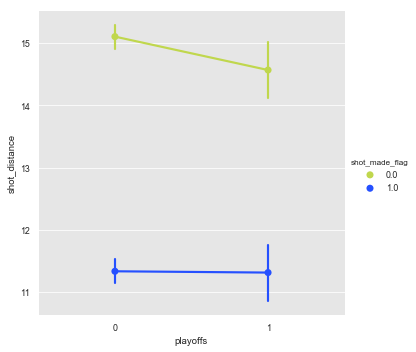

In [193]:
#g = sns.FacetGrid(kobe, hue="shot_made_flag", col="playoffs", height=4)
#g.mag(catplot, x="sex", y="survived", hue="class", kind="point", data=titanic)

sns.catplot(x="playoffs", y="shot_distance", hue="shot_made_flag", 
            kind="point", data=kobe);

#g.add_legend();

__Linear Association__ 

In [151]:

g.map(qqplot, "shot_distance", "shot_zone_range")


NameError: name 'qqplot' is not defined

In [90]:
short_v_midrange = sm.stats.Table2x2(shots_playoffs[['Less Than 8 ft.','8-16 ft.']].values)
short_v_farrange = sm.stats.Table2x2(shots_playoffs[['Less Than 8 ft.','16-24 ft.']].values)
short_v_deeeprange = sm.stats.Table2x2(shots_playoffs[['Less Than 8 ft.','24+ ft.']].values)


print("Playoffs:\n")
print("Less than 8tf. vs Midrange (8-16ft)")
print("Odds Ratio: ", short_v_midrange.oddsratio)
print("Confidence INterval: ", short_v_midrange.oddsratio_confint())

print("\nLess than 8tf. vs Far Range (16-24tf)")
print("Odds Ratio: ", short_v_farrange.oddsratio)
print("Confidence INterval: ", short_v_farrange.oddsratio_confint())

print("\nLess than 8tf. vs Deep Range (24+)")
print("Odds Ratio: ", short_v_deeeprange.oddsratio)
print("Confidence INterval: ", short_v_deeeprange.oddsratio_confint())

Playoffs:

Less than 8tf. vs Midrange (8-16ft)
Odds Ratio:  0.6635169053595157
Confidence INterval:  (0.546387295208074, 0.8057557113040342)

Less than 8tf. vs Far Range (16-24tf)
Odds Ratio:  0.5424273534794447
Confidence INterval:  (0.44772234612715156, 0.6571649513315895)

Less than 8tf. vs Deep Range (24+)
Odds Ratio:  0.4426093186964912
Confidence INterval:  (0.3568446744788252, 0.5489867805455978)


In [93]:

short_v_midrange = sm.stats.Table2x2(shots_seaon[['Less Than 8 ft.','8-16 ft.']].values)
short_v_farrange = sm.stats.Table2x2(shots_seaon[['Less Than 8 ft.','16-24 ft.']].values)
short_v_deeeprange = sm.stats.Table2x2(shots_seaon[['Less Than 8 ft.','24+ ft.']].values)


print("SEASON:\n")
print("Less than 8tf. vs Midrange (8-16ft)")
print("Odds Ratio: ", short_v_midrange.oddsratio)
print("Confidence INterval: ", short_v_midrange.oddsratio_confint())

print("\nLess than 8tf. vs Far Range (16-24tf)")
print("Odds Ratio: ", short_v_farrange.oddsratio)
print("Confidence INterval: ", short_v_farrange.oddsratio_confint())

print("\nLess than 8tf. vs Deep Range (24+)")
print("Odds Ratio: ", short_v_deeeprange.oddsratio)
print("Confidence INterval: ", short_v_deeeprange.oddsratio_confint())

SEASON:

Less than 8tf. vs Midrange (8-16ft)
Odds Ratio:  0.5664061943625461
Confidence INterval:  (0.5209601221371165, 0.6158167648152981)

Less than 8tf. vs Far Range (16-24tf)
Odds Ratio:  0.49929017757285826
Confidence INterval:  (0.46134419159441276, 0.5403572559550024)

Less than 8tf. vs Deep Range (24+)
Odds Ratio:  0.364419076320844
Confidence INterval:  (0.3338142408893802, 0.3978298314437242)


__Simsons Paradonx__

In [ ]:
tab.oddsratio

In [105]:

tb = pd.crosstab(train.playoffs, train.shot_made_flag).T.sort_values('shot_made_flag', ascending=False).T.sort_values('playoffs', ascending=False)
print(tb)
tab = sm.stats.Table2x2(tb.values)
chi2, p, dof, ex = stats.chi2_contingency(tb, correction=False)

print("Pearson's Chi-squared test with Yates' continuity correction")
print("X-squared: ", round(chi2, 3))
print("p-value  : ", round(p, 3))
print("degree of f: ", dof)

hi, low = tab.oddsratio_confint()
print("odds ratio", tab.oddsratio)
print("Odds Ratio CI: ", (round(hi, 3), round(low, 3)))
print("\n2x2 Summary:")
print(tab.summary())

shot_made_flag     1     0
playoffs                  
1               1345  1689
0               7921  9742
Pearson's Chi-squared test with Yates' continuity correction
X-squared:  0.277
p-value  :  0.599
degree of f:  1
odds ratio 0.9794014591545628
Odds Ratio CI:  (0.906, 1.058)

2x2 Summary:
               Estimate   SE   LCB    UCB  p-value
--------------------------------------------------
Odds ratio        0.979        0.906 1.058   0.599
Log odds ratio   -0.021 0.040 -0.098 0.057   0.599
Risk ratio        0.989        0.947 1.032   0.600
Log risk ratio   -0.012 0.022 -0.055 0.032   0.600
--------------------------------------------------


__interpretation__ The estimated odds of Kobe making a shot in the playoffs was 98% less likely than than making a shot in during the regular season. With a 95% confidence inteval of 0.906, 1.058, for $\theta$ does contain 1.0, the true odds __do not seem statistically different__ for the two groups.  were We are 95% confident the odds of Kobe making a shot in the playoffs the odds of kobe making the shot in the playoffs is 

In [ ]:
1345

In [333]:
(1345*9742) / (7921*1689)

0.9794014591545628

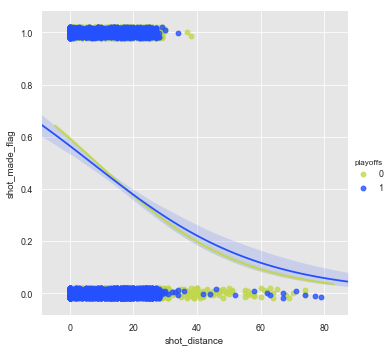

In [78]:
# shot probability as a function of shot distance and playoffs
sns.lmplot(x="shot_distance", y="shot_made_flag", data = kobe, hue="playoffs", y_jitter=.02, logistic=True)

Below are results from SAS to describe the `playoff` and `shot_made` associations. 
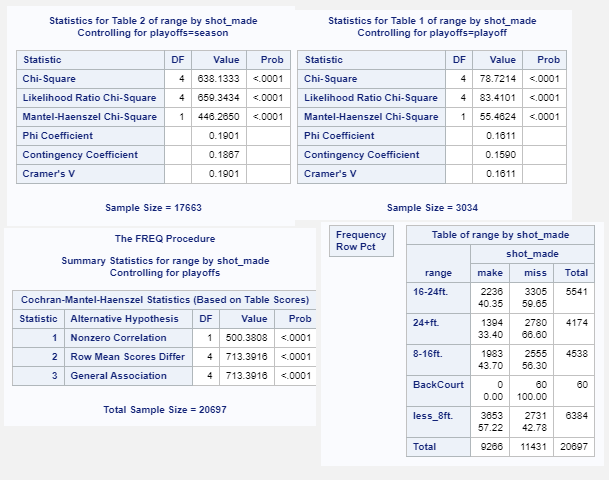

After reviewing the associations between kobe's shot performance during the `season` (top left plot) and `playoffs` (top right plot), the association are bot significant, but the season appears more significant, this is perhaps due to the umbalance in observations in the `playoffs`. This is also indicated by the Mantel-Haenszel table on the bottom left that used to assess the overall association while contrilling for playoffs.

___this may still be a conclusion for part 1... need to add comment about playoffs__. Overall, when assess Kobe's shot, with the frequency table on the bottom right, this indicates given shots at less distance from the basket, such as <8 ft, 57% were made baskets, while among shots at further distances shuch as 16-24ft. indicate around 60% that are misses. and with the assessment discribed above, all test provides significant evidence that the shot distance is associate between shot being made/missed and the distance. 

#### Homogeneity of Association 

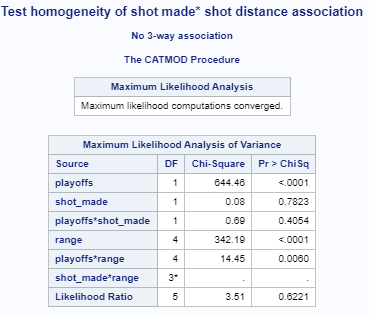

http://www.datavis.ca/courses/grcat/grc2.html

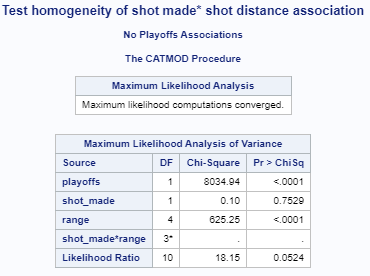



Above for the __Test of Homogeneity of associations__, `shot_made` when associated with `playoffs` and `range` are both not significant, indicating no homogenneity association, additionally, the likelihood ration for the `no-playoff` associations is borderline significant, and could be a canadiate for a reasonable model indicating a respectible fit.

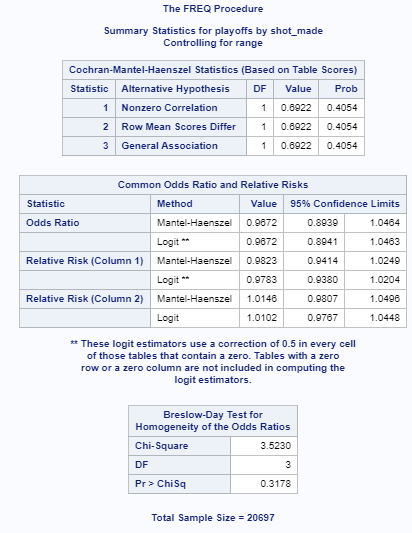

```sas
proc freq;
 weight count;
 tables range*playoffs*shot_made /chisq cmh nocol nopct;
run;
```

In [ ]:
sm.GLM

In [48]:
shots_made = sm.stats.Table(pd.crosstab(train.shot_made_flag, train.shot_type))
print(shots_made.table_orig)

shot_type       2PT Field Goal  3PT Field Goal
shot_made_flag                                
0                         8564            2867
1                         7850            1416


In [50]:
shots_made_result = shots_made.test_nominal_association()
print("Chi-Square Statistic: ", shots_made_result.statistic)
print("Chi-Square Probability (p-value): ", shots_made_result.pvalue)

Chi-Square Statistic:  299.43783980960814
Chi-Square Probability (p-value):  0.0


In [83]:
fig.set_size_inches(8,8)

In [90]:
sns.set(rc={'figure.figsize':(8,12)})

# The Kobe Curve

* Shot Selection
* Hot Hand

![](https://images.performgroup.com/di/library/NBA_Global_CMS_image_storage/57/1e/kobe40kb-statsjpg_glcsz6la4tmy12tppmmhnj1lg.jpg?t=1566641621&w=1080&quality=80)
[_(Getty Images)_](read://www.sportingnews.com/?url=https%3A%2F%2Fwww.sportingnews.com%2Fau%2Fnba%2Fnews%2Fkobe-bryant-birthday-40-stats-los-angeles-lakers%2F1h14i3wsgajrv1jrlmandv4kza)


Create a new variable to only acknoledge 1 quarter through OT with OT being the sum of 5-7.

In [201]:
kobe.period.unique()

array([1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [203]:
kobe['period_'] = kobe.period
kobe.loc[kobe.period_>4, "period_"] = "OT"

In [ ]:
kobe.hot_hand

['8-16 ft.' 'Less Than 8 ft.' '24+ ft.' '16-24 ft.' 'Back Court Shot']


Text(0.5, 1.0, 'Kobe period_ Distribution on Shots Made/Missed')

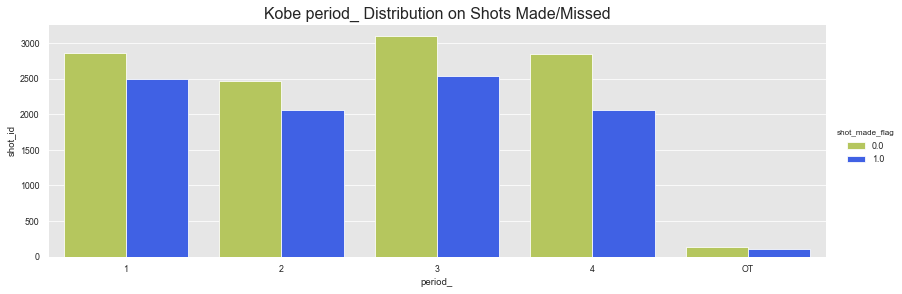

In [208]:
print(kobe.shot_zone_range.unique())
sns.catplot(x='period_', y='shot_id',
            hue='shot_made_flag', kind='bar', height=4, aspect=11.7/4,
           data=kobe.groupby(['period_','shot_made_flag'])['shot_id'].count().reset_index())
plt.title("Kobe period_ Distribution on Shots Made/Missed", fontsize=16)



In [213]:
kobe_qt = pd.crosstab([kobe.playoffs, kobe.period_],kobe.shot_made_flag)
qt = sm.stats.Table(kobe_qt)
kobe_qt

shot_made_flag    0.000  1.000
playoffs period_              
0        1         2454   2142
         2         2109   1755
         3         2688   2178
         4         2373   1751
         OT         118     95
1        1          413    352
         2          366    311
         3          413    360
         4          478    305
         OT          19     17

shot_made_flag    0.000  1.000
playoffs period_              
0        1         2454   2142
         2         2109   1755
         3         2688   2178
         4         2373   1751
         OT         118     95
1        1          413    352
         2          366    311
         3          413    360
         4          478    305
         OT          19     17